In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [3]:
def LoadDailyData(year):
    
    df_hourly = pd.read_excel("satni podaci.xlsx", sheet_name=year)
    df_hourly.loc[1, "Vrijeme"] = "01.01." + year
    
    date_pattern = re.compile(r'\d{2}\.\d{2}\.\d{4}')
    dates_list = df_hourly['Vrijeme'].apply(lambda x: x if isinstance(x, str) and date_pattern.match(x) else None).dropna().tolist()
    
    df_hourly= df_hourly[3:]
    rows_to_keep = []

    chunk_size = 27
    for i in range(0, len(df_hourly), chunk_size):
        rows_to_keep.extend(range(i, i + 24))

    df_hourly = df_hourly.iloc[rows_to_keep]


    df_hourly.reset_index(drop=True, inplace=True)
    
    num_days = len(df_hourly) // 24
    daily_data = []

    for i in range(num_days):
        daily_chunk = df_hourly.iloc[i*24:(i+1)*24]
        daily_sum = daily_chunk.sum(numeric_only=True)
        daily_data.append(daily_sum)

    df_daily = pd.DataFrame(daily_data)
    df_daily["Datum"] = dates_list
    
    if year == "2020" or year == "2019":
        df_daily.drop(columns=[df_daily.columns[0]], inplace=True)

    
    return df_daily            

In [4]:
def stackDataVertically(df_2019, df_2020, df_2021, df_2022):
    dfs = [df_2019, df_2020, df_2021, df_2022]
    return pd.concat(dfs, ignore_index=True)

In [5]:
def visualizeEnergyPorduction(data):
    columns = list(data.columns)
    if "Datum" in columns:
        columns.remove("Datum")
    num_cols = 4
    num_rows = (len(columns) - 1) // num_cols + 1 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 25))

    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]
        ax.plot(data[column])
        ax.set_title(column)


    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

In [6]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {:.3f} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v < dftest[0] else '', 100-int(k[:-1])))
    return dftest[1]

In [7]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, regression='c'):
    statistic, p_value, lags, critical_values = kpss(series, regression=regression)
    return {
        'KPSS Statistic': statistic,
        'p-value': p_value,
        'Lags': lags,
        'Critical Values': critical_values
    }

# Function to interpret KPSS test results at different confidence levels
def interpret_kpss_test(kpss_result):
    print(f"KPSS Statistic: {kpss_result['KPSS Statistic']}")
    print(f"p-value: {kpss_result['p-value']}")
    print(f"Lags: {kpss_result['Lags']}")
    print("Critical Values:")
    for key, value in kpss_result['Critical Values'].items():
        print(f'   {key}: {value}')
    
    significance_levels = [1, 5, 10]
    for level in significance_levels:
        critical_value = kpss_result['Critical Values'][f'{level}%']
        if kpss_result['KPSS Statistic'] > critical_value:
            print(f"At {level}% significance level, the series is NOT stationary.")
        else:
            print(f"At {level}% significance level, the series is stationary.")

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose(timeseries):
    result = seasonal_decompose(timeseries, model='additive', period=250)  # Adjust period for your data

    # Plot the decomposition
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(result.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(result.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [9]:
df_2022_daily = LoadDailyData("2022")
df_2021_daily = LoadDailyData("2021")
df_2020_daily = LoadDailyData("2020")
df_2019_daily = LoadDailyData("2019")


In [10]:
daily_data = stackDataVertically(df_2019_daily, df_2020_daily, df_2021_daily, df_2022_daily)

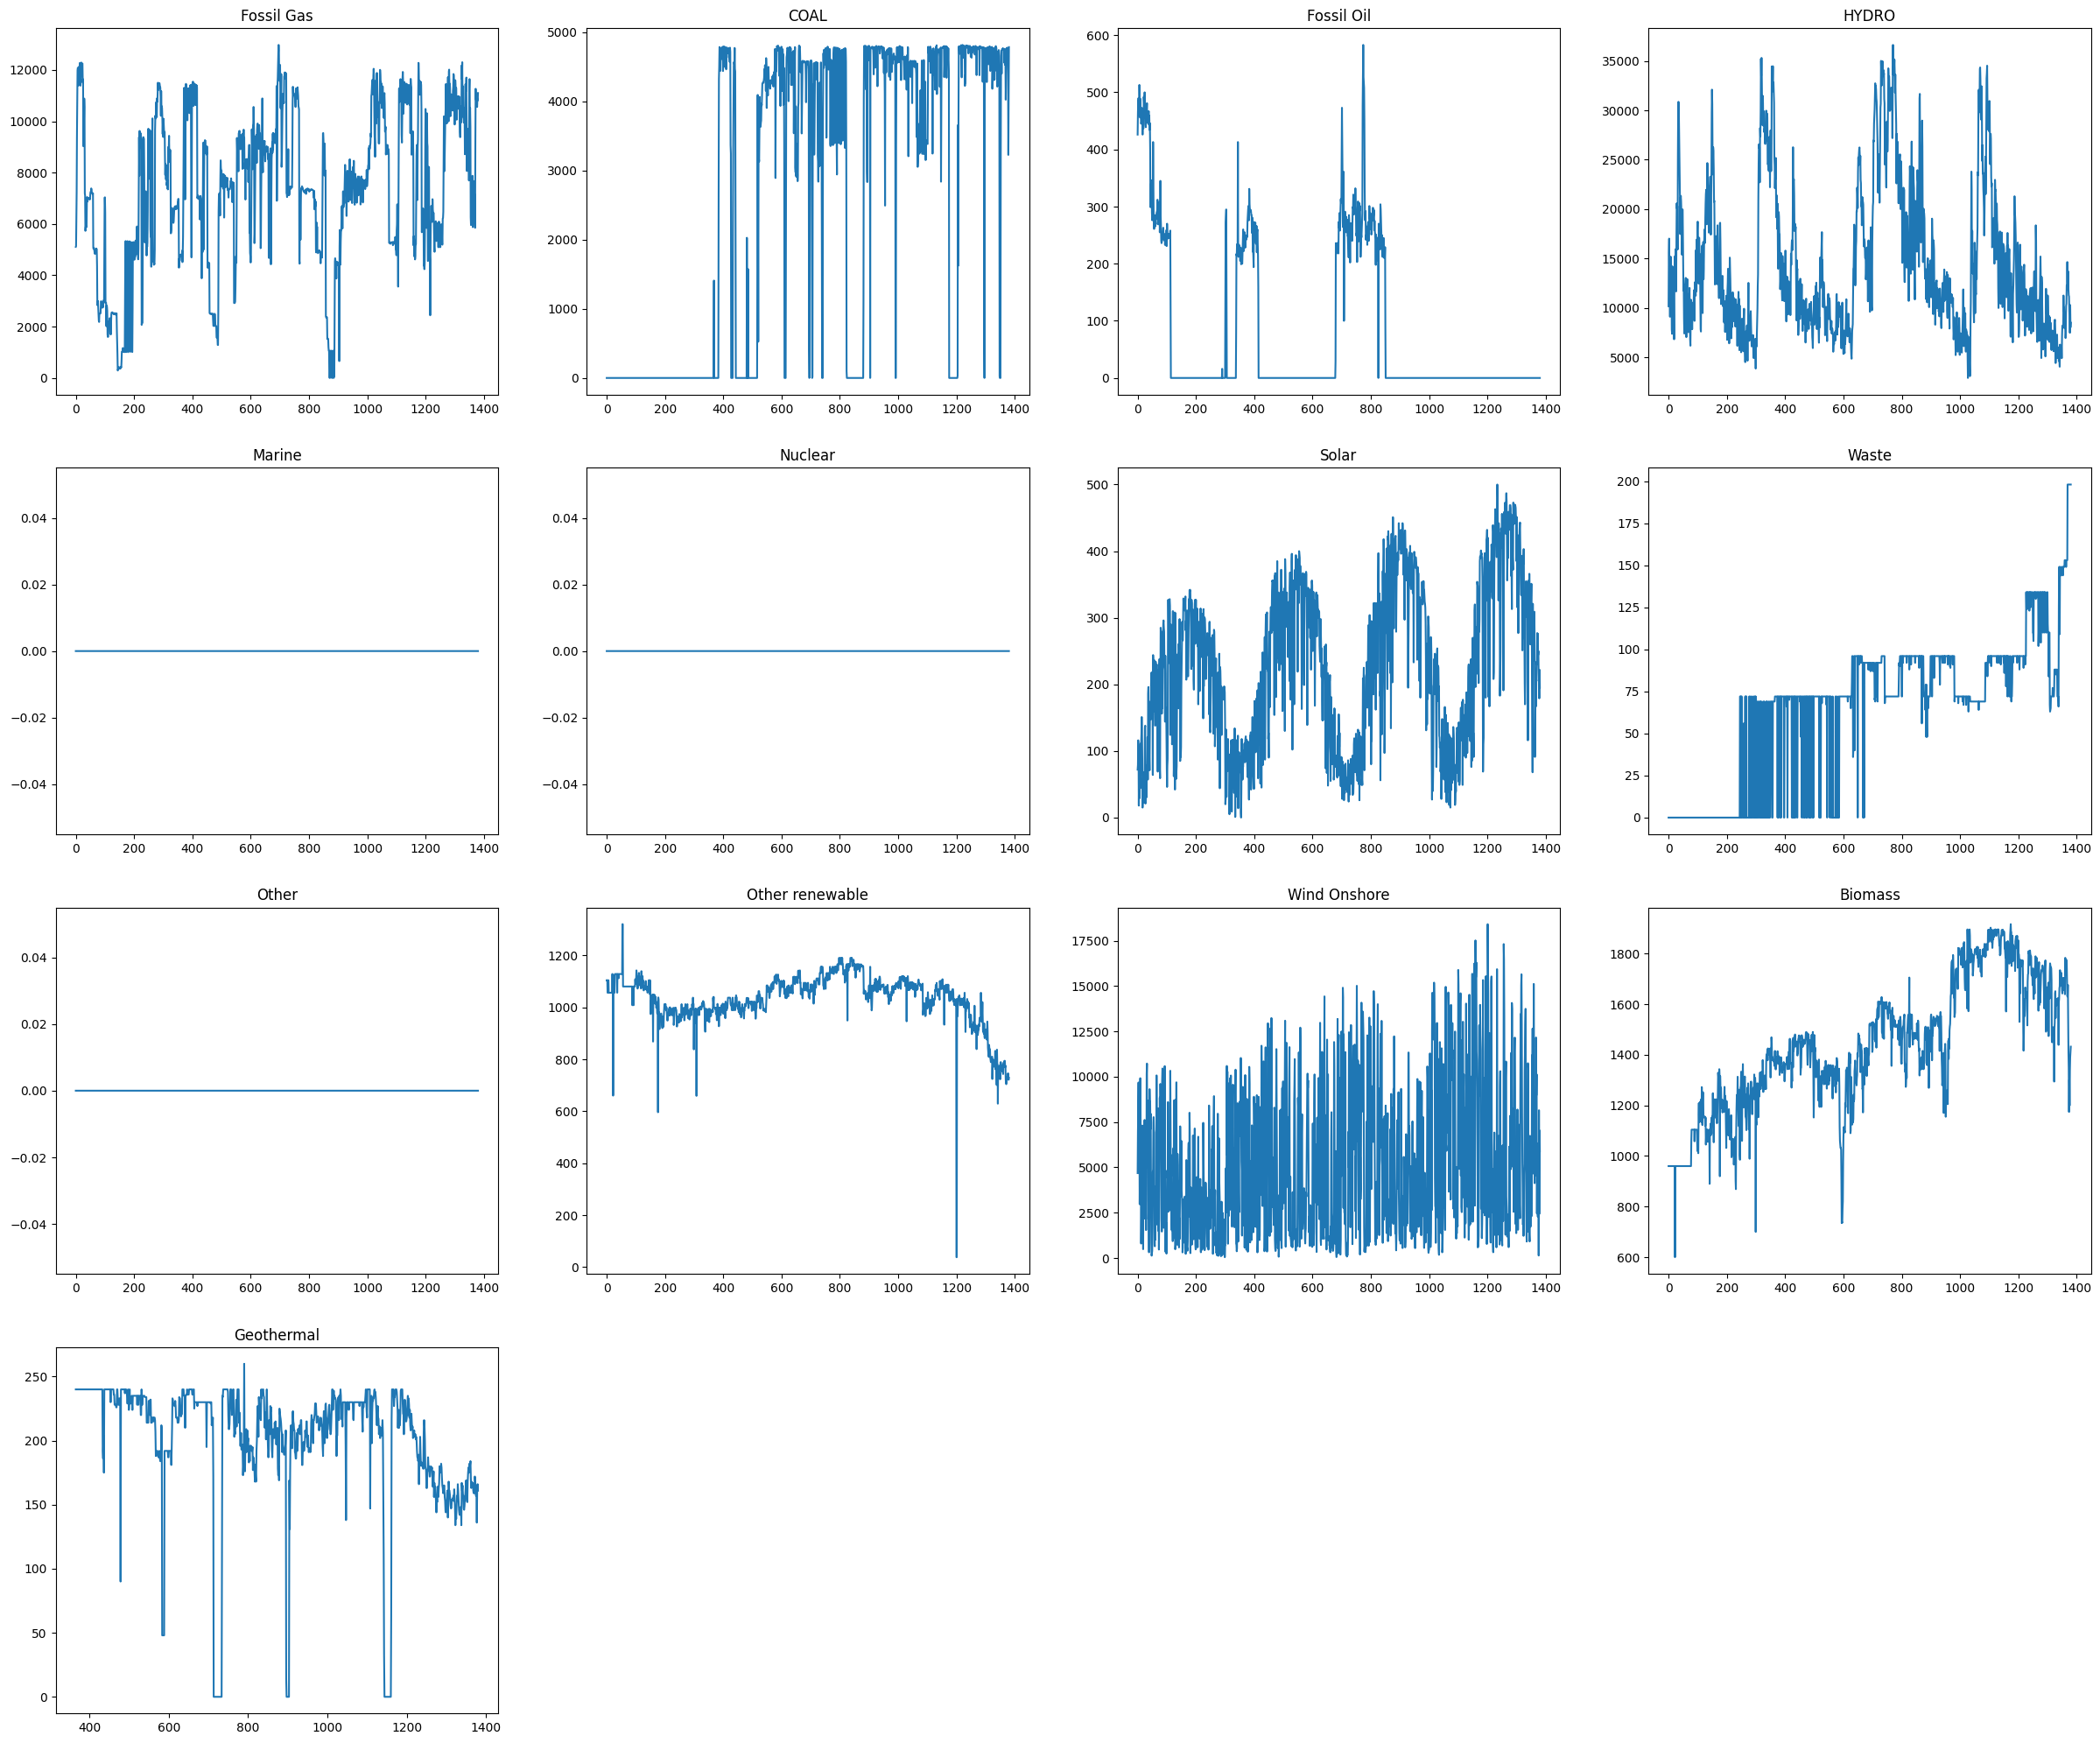

In [11]:
visualizeEnergyPorduction(daily_data)

In [12]:
df_2019_yearly = pd.DataFrame(df_2019_daily.sum(axis= 0)).T.drop(columns="Datum")
df_2020_yearly = pd.DataFrame(df_2020_daily.sum(axis= 0)).T.drop(columns="Datum")
df_2021_yearly = pd.DataFrame(df_2021_daily.sum(axis= 0)).T.drop(columns="Datum")
df_2022_yearly = pd.DataFrame(df_2022_daily.sum(axis= 0)).T.drop(columns="Datum")

In [13]:
yearly_data = stackDataVertically(df_2019_yearly, df_2020_yearly, df_2021_yearly, df_2022_yearly)

In [14]:
yearly_data

Fossil Gas       COAL Fossil Oil      HYDRO Marine Nuclear    Solar  \
0  2151513.0        0.0    46344.0  5529984.0    0.0     0.0  66894.0   
1  2908852.0  1101303.0    26634.0  4955117.0    0.0     0.0  78132.0   
2  2627262.0  1317314.0    32781.0  6479549.0    0.0     0.0  85112.0   
3  2499338.0  1144806.0        0.0  3390915.0    0.0     0.0  86160.0   

     Waste Other Other renewable Wind Onshore   Biomass Geothermal  
0   3155.0   0.0        374265.0    1445070.0  417508.0        NaN  
1  23558.0   0.0        382063.0    1702736.0  497575.0    78104.0  
2  30207.0   0.0        402295.0    2051069.0  576303.0    75426.0  
3  31717.0   0.0        267220.0    1815558.0  491253.0    50299.0

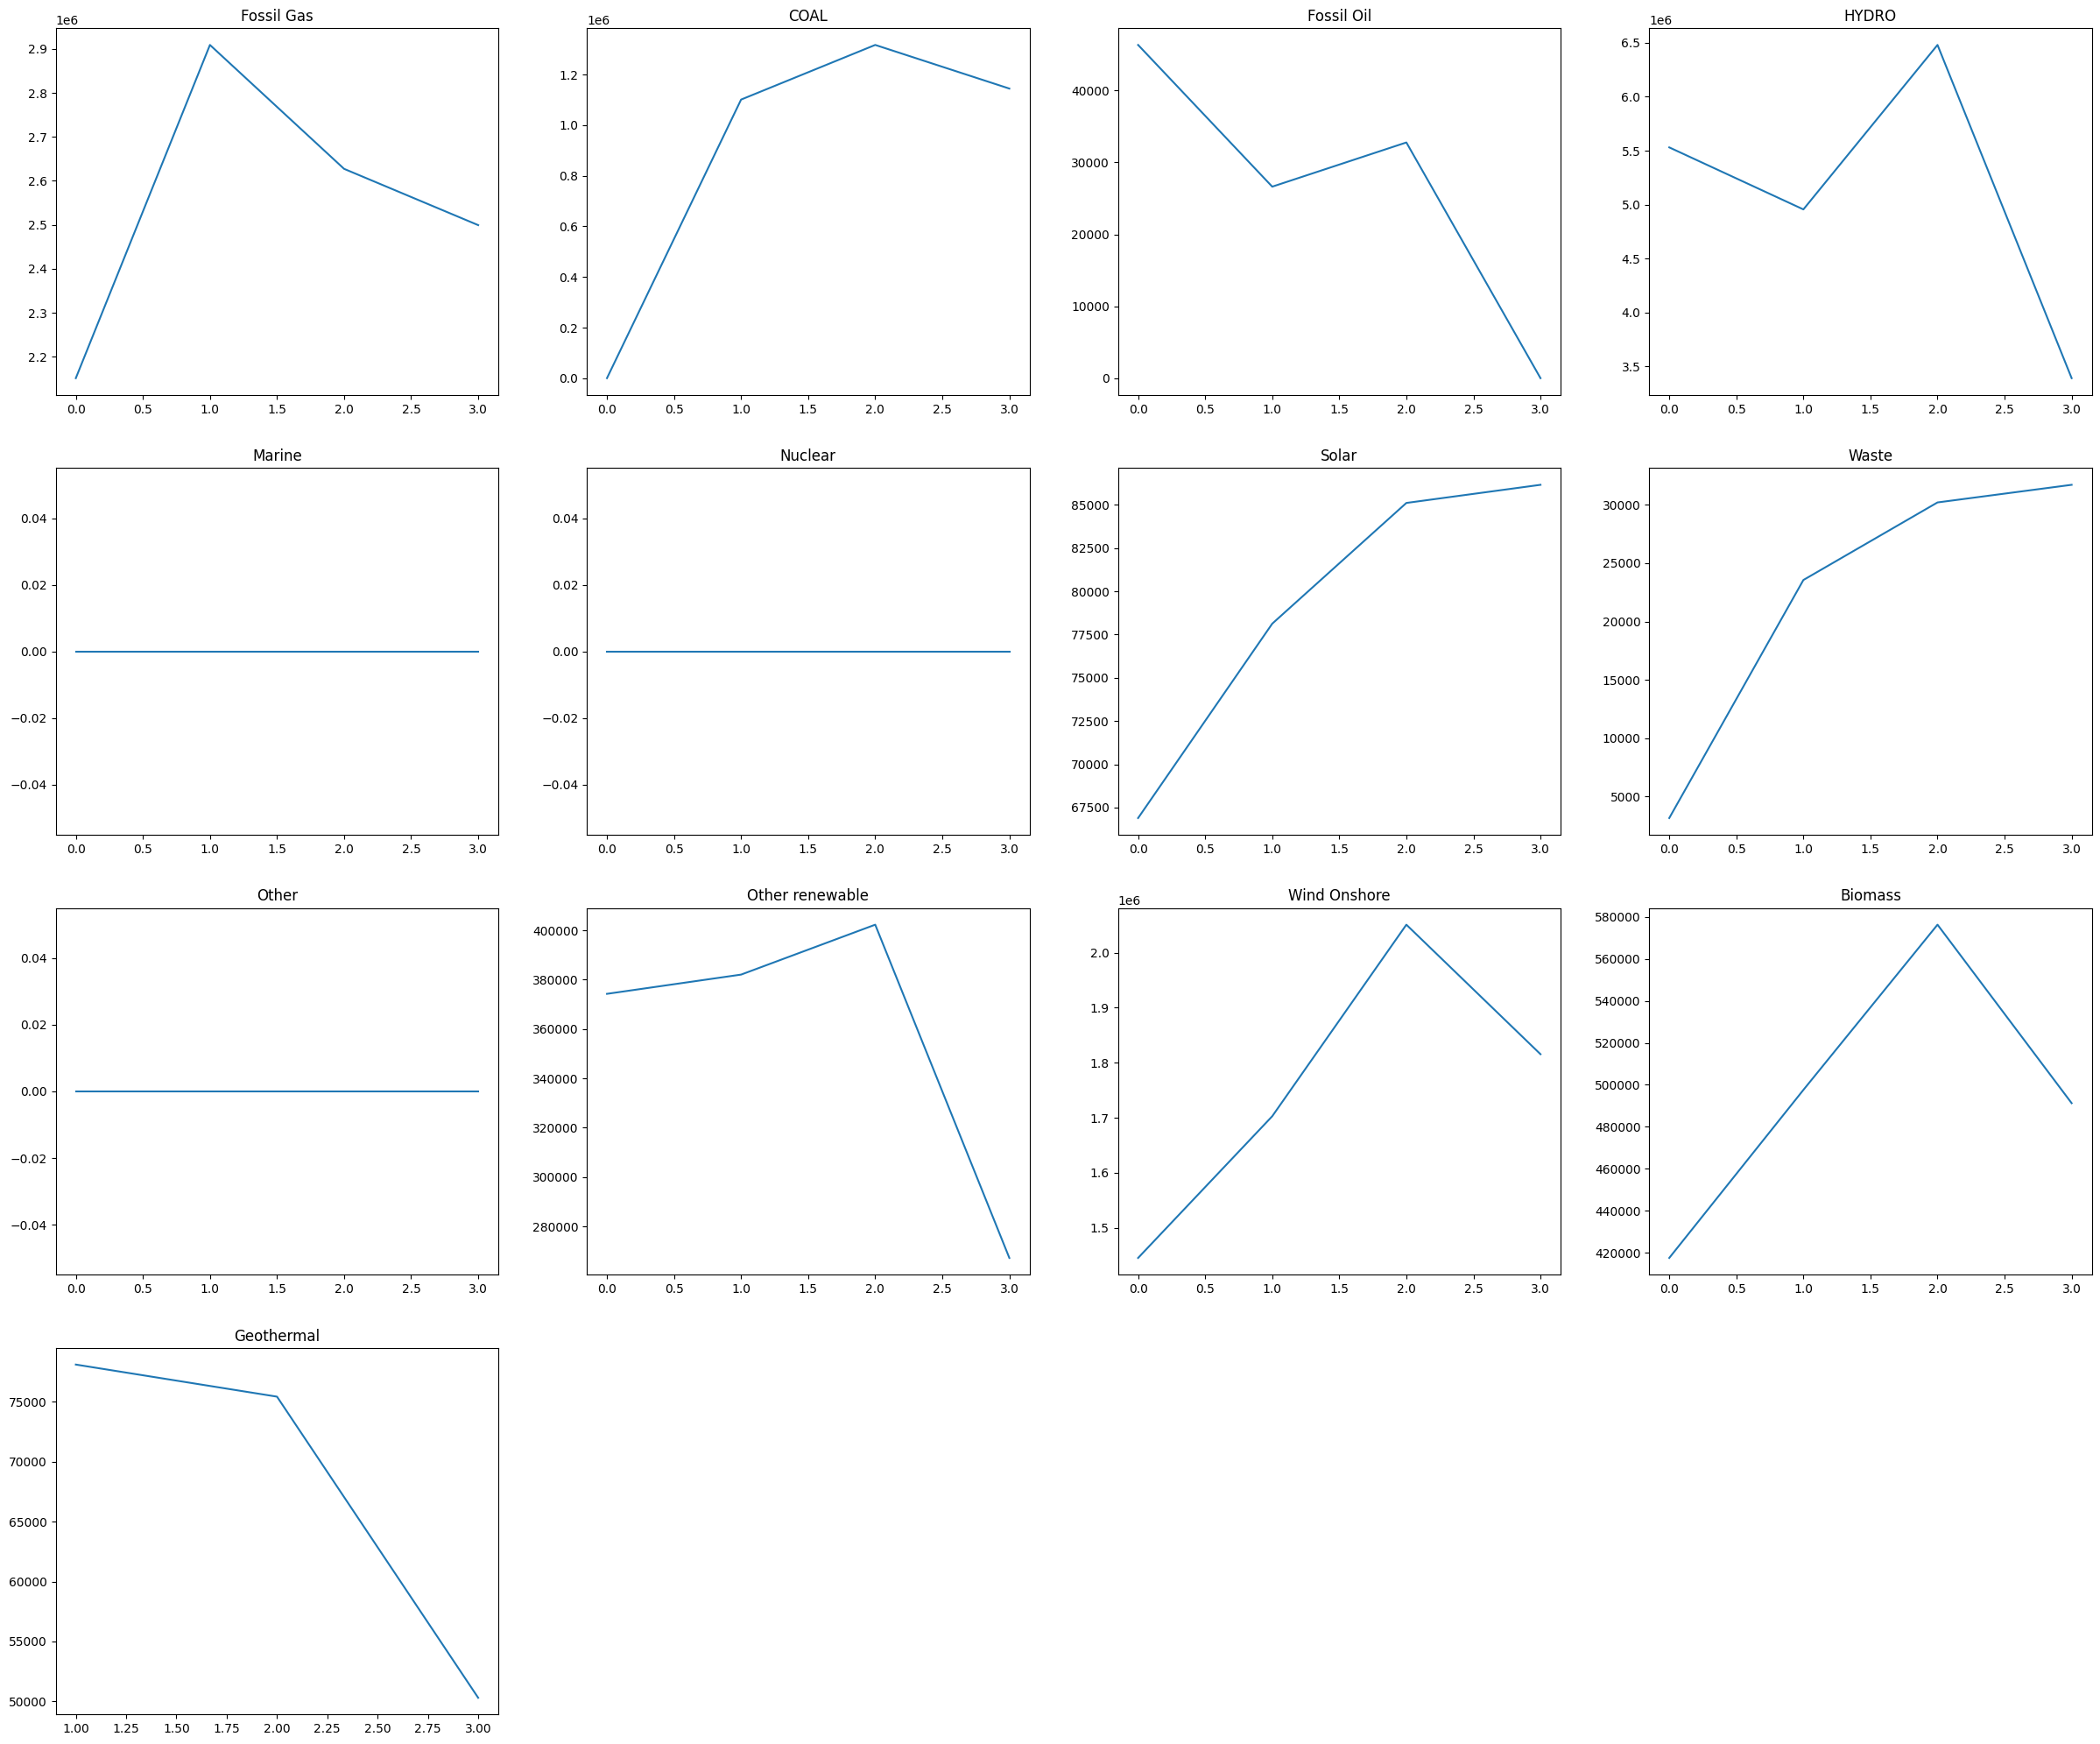

In [15]:
visualizeEnergyPorduction(yearly_data)

In [16]:
daily_data["Obnovljivi"] = daily_data["HYDRO"] + daily_data["Solar"] + daily_data["Other renewable"] + daily_data["Wind Onshore"] + daily_data["Biomass"]

In [17]:
current_price = pd.read_excel("struja dnevni podaci 2019-2022.xlsx")
current_price

dnevne Unnamed: 1        EPEX   EPEX - AT          SP         GME  \
0    2019-01-01        uto   -4.297083   15.070833   36.554913   44.102080   
1    2019-01-02        sri   25.917500   35.503750   52.980127         NaN   
2    2019-01-03        čet   57.716250   59.345833   61.433784   59.738333   
3    2019-01-04        pet   49.910000   53.952083   66.302455   67.234604   
4    2019-01-05        sub   42.180833   52.526250   63.445259   68.234166   
...         ...        ...         ...         ...         ...         ...   
1347 2022-09-09        pet  345.700000  362.601250  383.934167  445.637083   
1348 2022-09-10        sub  404.317917  404.317917  404.317917  425.377917   
1349 2022-09-11        ned  391.489167  391.489167  391.529167  405.204167   
1350 2022-09-12        pon  408.030833  419.818333  438.681250  451.565833   
1351 2022-09-13        uto  392.370000  421.177083  448.822083  457.518750   

            HUPX       OPCOM      SEEPEX      CROPEX  
0      46.025833   46.025833   52.372917   36.554583  
1      50.742083   48.474167   61.182083   52.980417  
2      73.767917   73.421250   68.818750   61.434167  
3      79.442917   76.147083   78.340000   66.302083  
4      60.387500   62.121250   77.581667   63.445000  
...          ...         ...         ...         ...  
1347  384.767500  305.964583  425.663333  377.266250  
1348  404.317917  404.317917  380.924583  404.317917  
1349  391.643750  391.650833  376.625417  391.565833  
1350  436.372917  435.877500  450.275417  437.792917  
1351  448.650833  448.892500  450.105833  448.740417  

[1352 rows x 10 columns]

In [18]:
current_price['dnevne'] = current_price['dnevne'].dt.strftime('%d.%m.%Y')
current_price.rename(columns={"dnevne": "Datum"}, inplace=True)
current_price = current_price[["Datum", "CROPEX"]]

In [19]:
daily_current_energy_data = data = pd.merge(daily_data, current_price)

In [20]:
daily_current_energy_data

Fossil Gas    COAL  Fossil Oil    HYDRO  Marine  Nuclear  Solar  Waste  \
0         5107.0     0.0       426.0  10163.0     0.0      0.0   72.0    0.0   
1         5136.0     0.0       465.0  15578.0     0.0      0.0   79.0    0.0   
2         6123.0     0.0       483.0  17011.0     0.0      0.0  116.0    0.0   
3         7256.0     0.0       490.0  13418.0     0.0      0.0  104.0    0.0   
4         9411.0     0.0       466.0  13545.0     0.0      0.0   18.0    0.0   
...          ...     ...         ...      ...     ...      ...    ...    ...   
1347      9587.0  4460.0         0.0   5286.0     0.0      0.0  260.0  144.0   
1348      9719.0    25.0         0.0   6082.0     0.0      0.0  317.0  149.0   
1349      7693.0     0.0         0.0   4905.0     0.0      0.0  308.0  149.0   
1350     11263.0     0.0         0.0   7117.0     0.0      0.0  331.0  149.0   
1351     11644.0     0.0         0.0   8141.0     0.0      0.0  351.0  149.0   

      Other  Other renewable  Wind Onshore  Biomass       Datum  Geothermal  \
0       0.0           1104.0        4684.0    960.0  01.01.2019         NaN   
1       0.0           1104.0        6981.0    960.0  02.01.2019         NaN   
2       0.0           1104.0        7999.0    960.0  03.01.2019         NaN   
3       0.0           1056.0        9682.0    960.0  04.01.2019         NaN   
4       0.0           1104.0        4678.0    960.0  05.01.2019         NaN   
...     ...              ...           ...      ...         ...         ...   
1347    0.0            775.0        3898.0   1724.0  09.09.2022       155.0   
1348    0.0            747.0        1726.0   1673.0  10.09.2022       158.0   
1349    0.0            747.0        4213.0   1693.0  11.09.2022       164.0   
1350    0.0            723.0        5536.0   1654.0  12.09.2022       169.0   
1351    0.0            788.0        2296.0   1642.0  13.09.2022       161.0   

      Obnovljivi      CROPEX  
0        16983.0   36.554583  
1        24702.0   52.980417  
2        27190.0   61.434167  
3        25220.0   66.302083  
4        20305.0   63.445000  
...          ...         ...  
1347     11943.0  377.266250  
1348     10545.0  404.317917  
1349     11866.0  391.565833  
1350     15361.0  437.792917  
1351     13218.0  448.740417  

[1352 rows x 16 columns]

c:\Users\Zoran Barac\miniconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Zoran Barac\miniconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


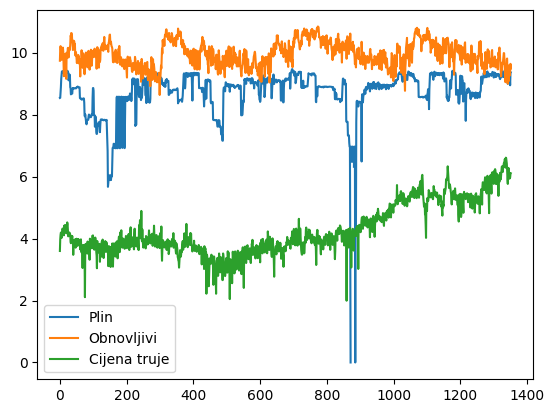

In [21]:
import numpy as np


plt.plot(np.log(daily_current_energy_data["Fossil Gas"]))
plt.plot(np.log(daily_current_energy_data["Obnovljivi"]))
plt.plot(np.log(daily_current_energy_data["CROPEX"]))

plt.legend(["Plin", "Obnovljivi", "Cijena truje"])

<h1> 1. Testiranje stacionarnosti </h1>

In [22]:
cijena_struje = daily_current_energy_data["CROPEX"]
plin = daily_current_energy_data["Fossil Gas"]
obnovljivi = daily_current_energy_data["Obnovljivi"]

In [23]:
ADF_test(cijena_struje, "Cijena struje")

 > Is the Cijena struje stationary?
Test statistic = 1.527
P-value = 0.998
Critical values :
	1%: -3.435 - The data is not stationary with 99% confidence
	5%: -2.864 - The data is not stationary with 95% confidence
	10%: -2.568 - The data is not stationary with 90% confidence


0.9976210519591899

In [24]:
ADF_test(plin, "Plin")

 > Is the Plin stationary?


Test statistic = -3.954
P-value = 0.002
Critical values :
	1%: -3.435 - The data is  stationary with 99% confidence
	5%: -2.864 - The data is  stationary with 95% confidence
	10%: -2.568 - The data is  stationary with 90% confidence


0.001674442059506689

In [25]:
ADF_test(obnovljivi, "Obnovljivi")

 > Is the Obnovljivi stationary?
Test statistic = -3.160
P-value = 0.022
Critical values :
	1%: -3.435 - The data is not stationary with 99% confidence
	5%: -2.864 - The data is  stationary with 95% confidence
	10%: -2.568 - The data is  stationary with 90% confidence


0.022410769125268702

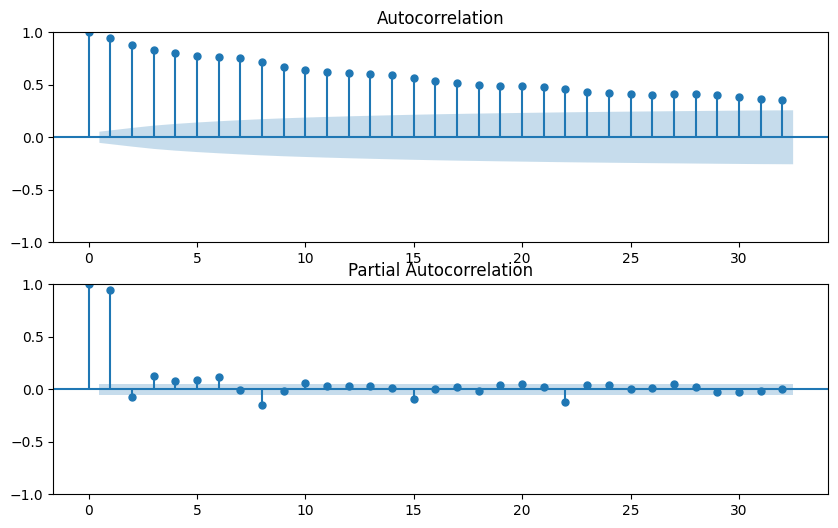

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

fig, ax = plt.subplots(2, figsize=(10,6))
ax[0] = plot_acf(plin, ax=ax[0])
ax[1] = plot_pacf(plin, ax=ax[1])

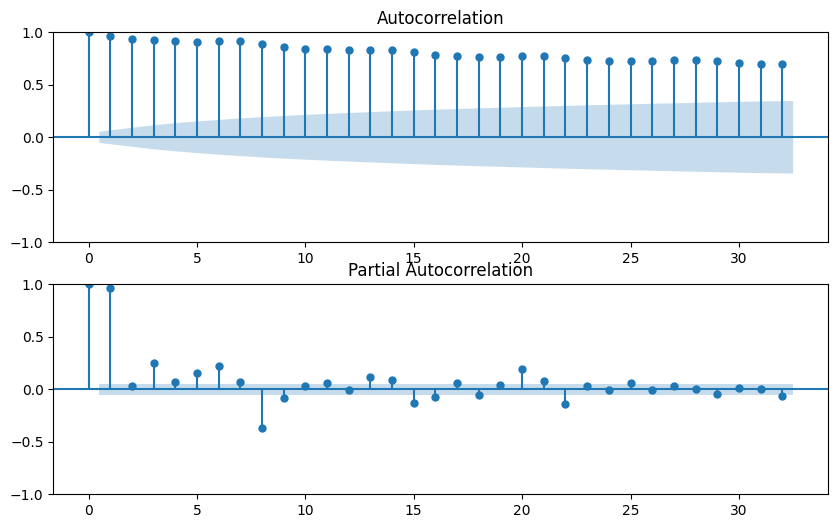

In [27]:
fig, ax = plt.subplots(2, figsize=(10,6))
ax[0] = plot_acf(cijena_struje, ax=ax[0])
ax[1] = plot_pacf(cijena_struje, ax=ax[1])

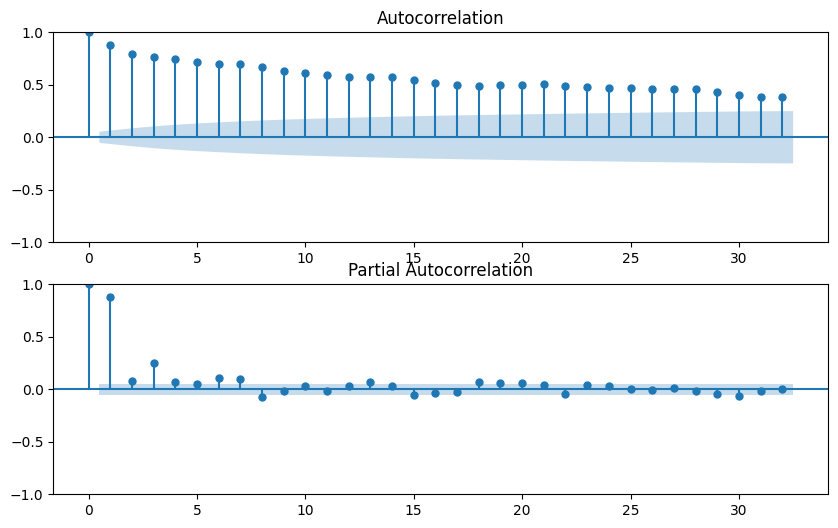

In [28]:
fig, ax = plt.subplots(2, figsize=(10,6))
ax[0] = plot_acf(obnovljivi, ax=ax[0])
ax[1] = plot_pacf(obnovljivi, ax=ax[1])

In [29]:
from pandas.plotting import lag_plot

def lag_plots():
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    lag_plot(cijena_struje, ax=ax1)
    ax1.set_title("Cijena_struje");

    lag_plot(plin, ax=ax2)
    ax2.set_title("Plin");
    
    lag_plot(obnovljivi, ax=ax3)
    ax3.set_title("Obnovljivi");

    #ax1.set_ylabel('$y_{t+1}$');
    #ax1.set_xlabel('$y_t$');
    
    #ax2.set_ylabel('$y_{t+1}$');
    #ax2.set_xlabel('$y_t$');
    

    plt.tight_layout()

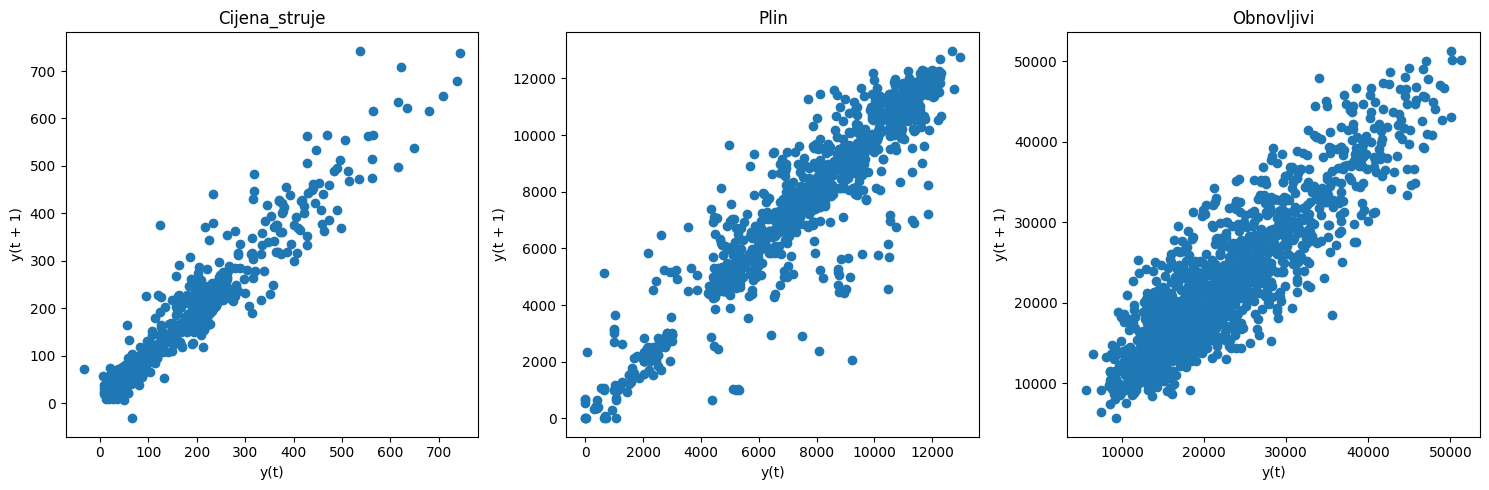

In [30]:
lag_plots()


In [31]:
df = pd.DataFrame({
    'electricity_prices': cijena_struje,
    'gas_production': plin,
    'renewable_production': obnovljivi
})

In [32]:
for column in df.columns:
    print(f"Results for {column}:")
    kpss_result = kpss_test(df[column])
    interpret_kpss_test(kpss_result)
    print("\n")

Results for electricity_prices:
KPSS Statistic: 3.8834236475867234
p-value: 0.01
Lags: 21
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
At 1% significance level, the series is NOT stationary.
At 5% significance level, the series is NOT stationary.
At 10% significance level, the series is NOT stationary.


Results for gas_production:
KPSS Statistic: 0.8719037525887274
p-value: 0.01
Lags: 20
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
At 1% significance level, the series is NOT stationary.
At 5% significance level, the series is NOT stationary.
At 10% significance level, the series is NOT stationary.


Results for renewable_production:
KPSS Statistic: 0.2815338293865091
p-value: 0.1
Lags: 20
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
At 1% significance level, the series is stationary.
At 5% significance level, the series is stationary.
At 10% significance level, the series is stationary.




C:\Users\Zoran Barac\AppData\Local\Temp\ipykernel_3652\1632610036.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, regression=regression)
C:\Users\Zoran Barac\AppData\Local\Temp\ipykernel_3652\1632610036.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, regression=regression)
C:\Users\Zoran Barac\AppData\Local\Temp\ipykernel_3652\1632610036.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, regression=regression)


In [33]:
def check_rolling(timeseries):
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend()
    plt.show()


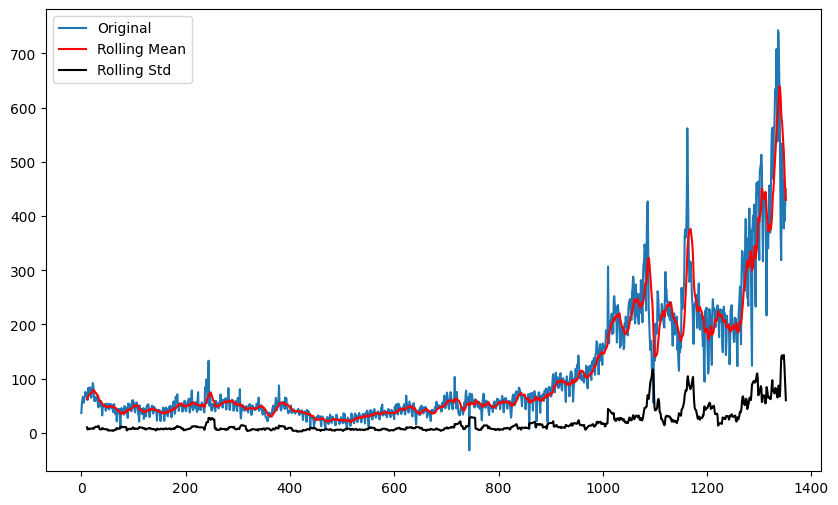

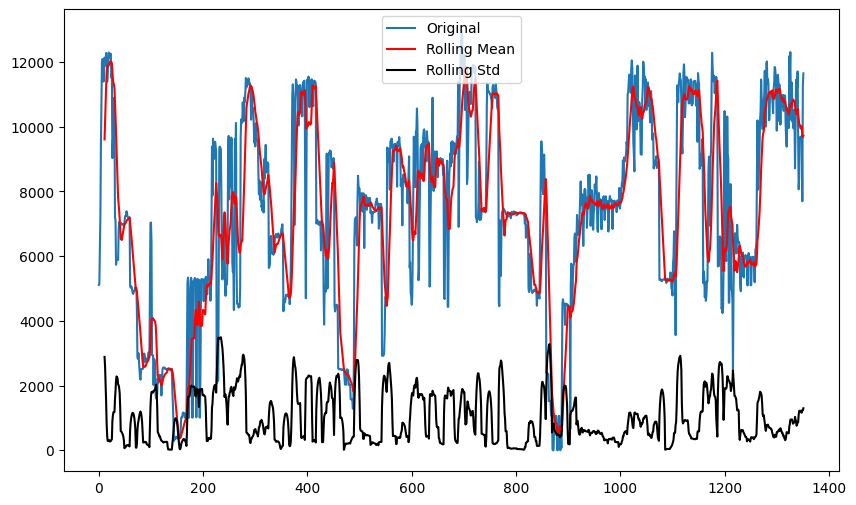

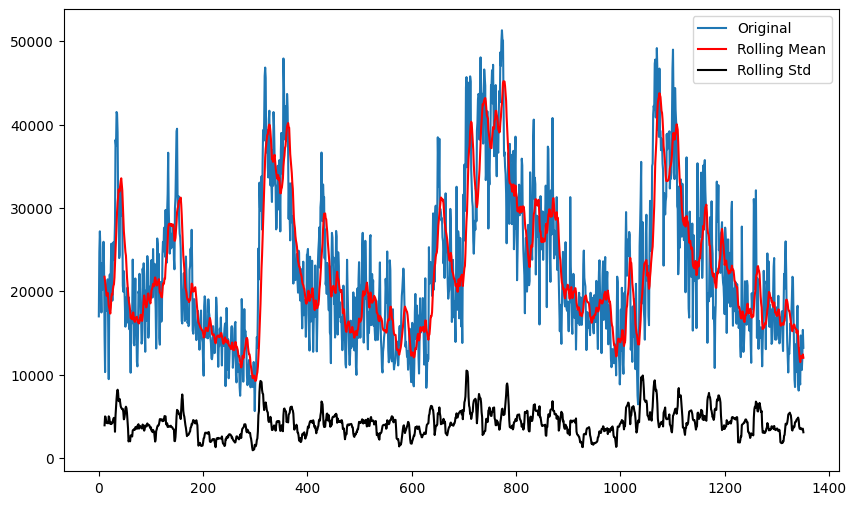

In [34]:
check_rolling(cijena_struje)
check_rolling(plin)
check_rolling(obnovljivi)

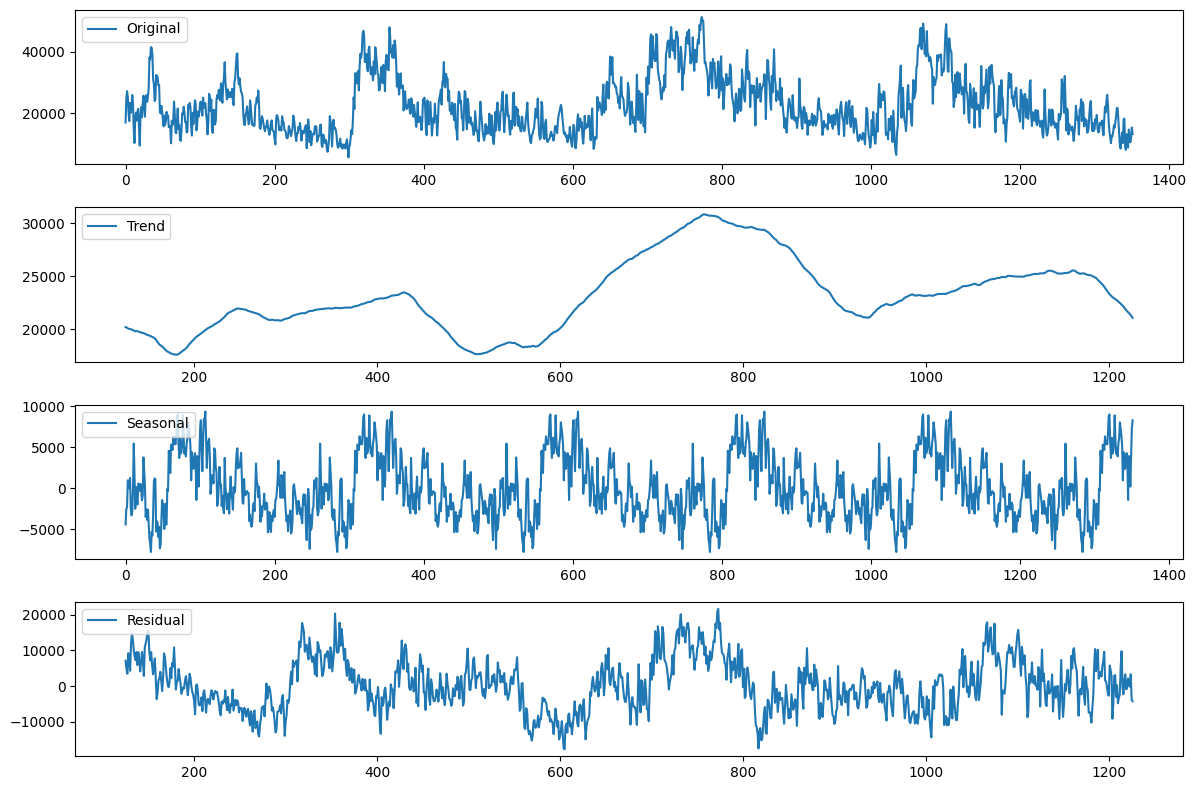

In [35]:
decompose(obnovljivi)

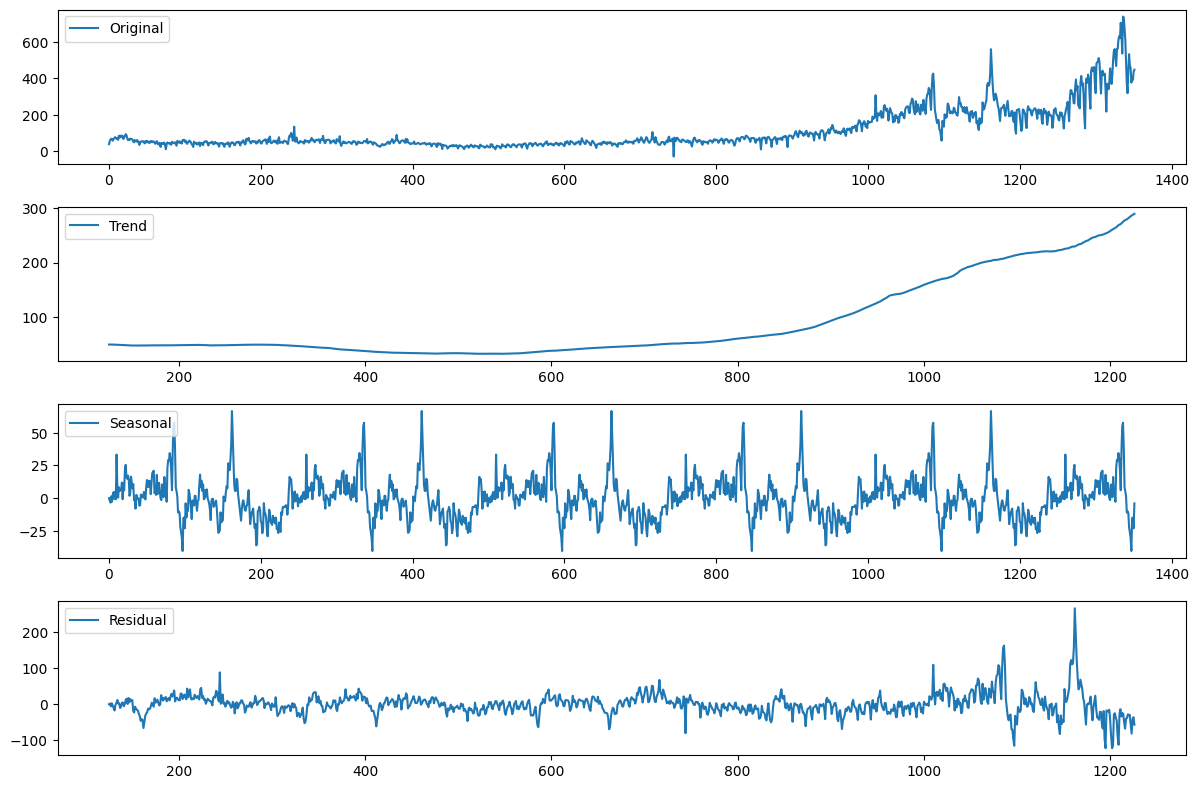

In [36]:
decompose(cijena_struje)

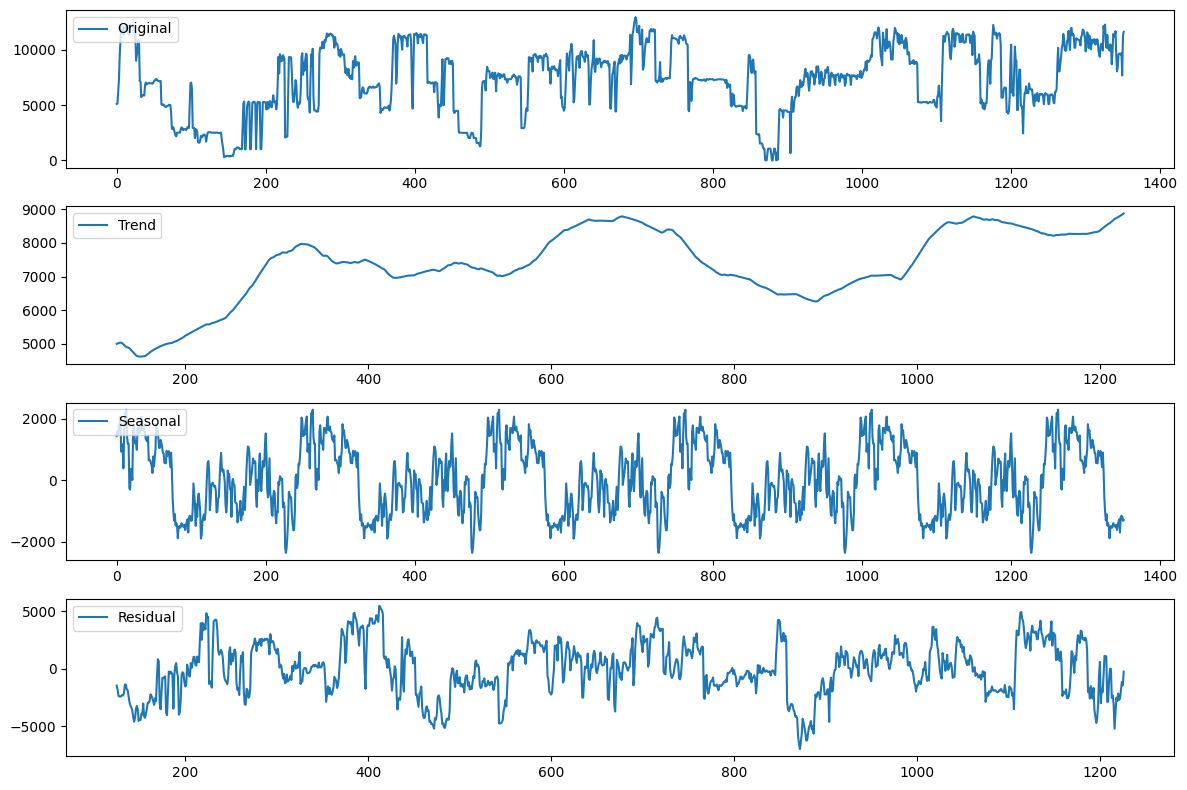

In [37]:
decompose(plin)

<h1> 2. Standardiziranje </h1>

In [38]:
df = pd.DataFrame({
    'electricity_prices': (cijena_struje),
    'gas_production': plin,
    'renewable_production': obnovljivi
})

In [39]:
from sklearn.preprocessing import StandardScaler

def standardize_data(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)
    return scaled_df, scaler

# Usage
standardizirani_podaci, scaler = standardize_data(df)


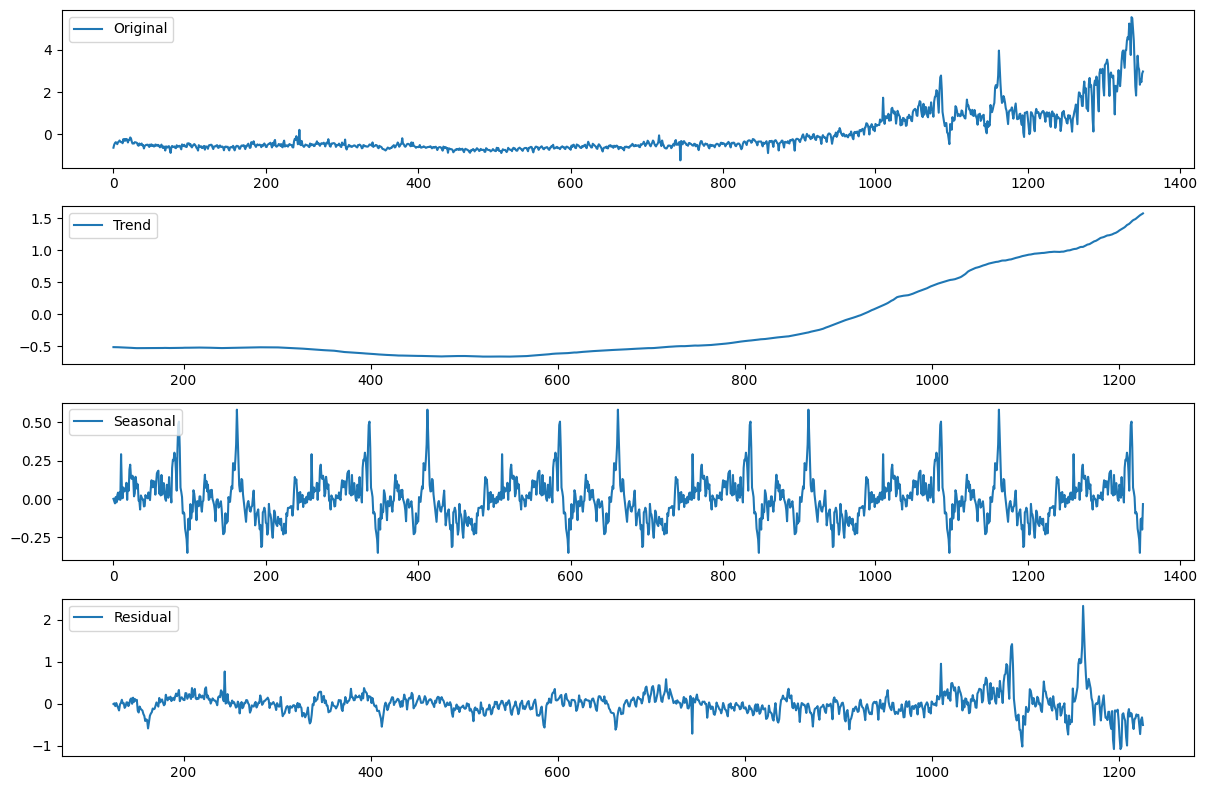

In [40]:
decompose(standardizirani_podaci["electricity_prices"])

<h1> 3. Diferenciranje </h3>

In [41]:
def difference_until_stationary(series):
    d = 0
    while adfuller(series)[1] > 0.05:
        series = series.diff().dropna()
        d += 1
    return series, d

In [42]:
standardizirani_podaci["electricity_prices"], d1 = difference_until_stationary(pd.DataFrame(standardizirani_podaci["electricity_prices"]))


In [43]:
standardizirani_podaci = standardizirani_podaci.dropna()

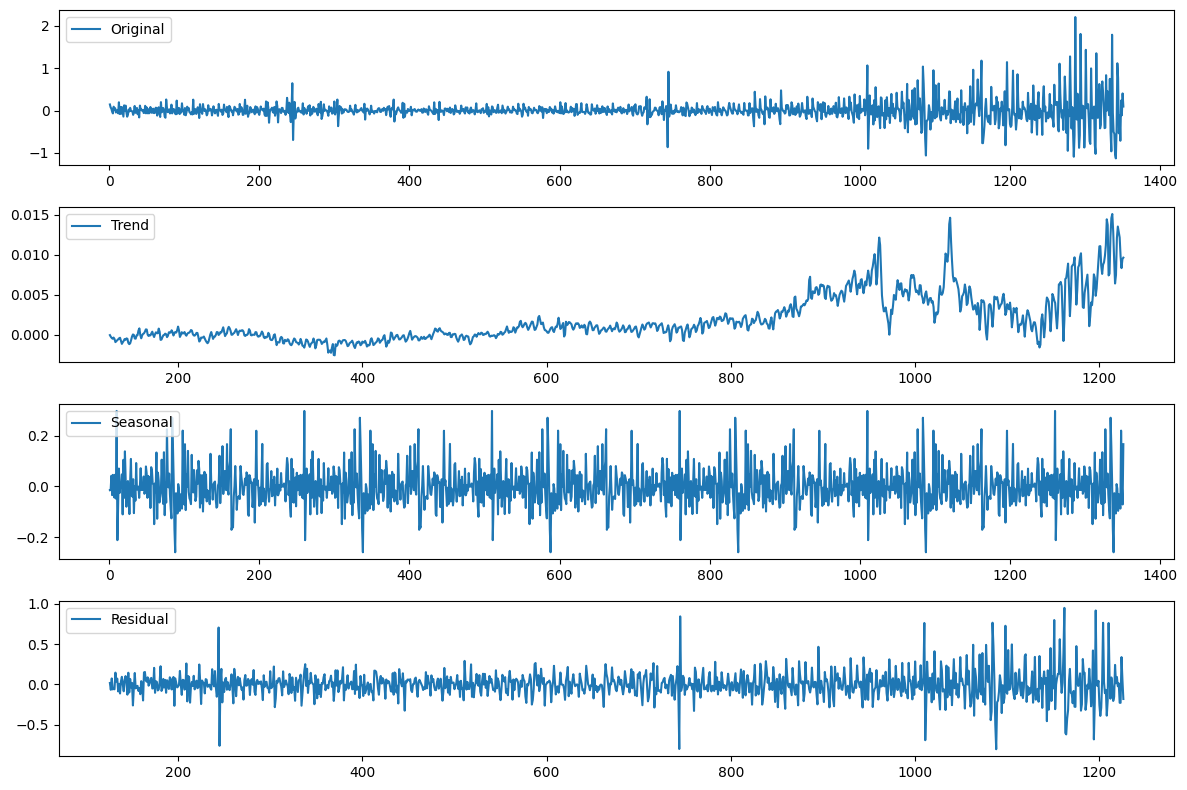

In [44]:
decompose(standardizirani_podaci["electricity_prices"])

In [45]:
ADF_test(standardizirani_podaci["electricity_prices"], "struja")

 > Is the struja stationary?
Test statistic = -10.713
P-value = 0.000
Critical values :
	1%: -3.435 - The data is  stationary with 99% confidence
	5%: -2.864 - The data is  stationary with 95% confidence
	10%: -2.568 - The data is  stationary with 90% confidence


3.2962271791611764e-19

<h1> 4. Pronalaženje optimalnog lagga p </h1>

In [46]:
from statsmodels.tsa.vector_ar.var_model import VAR

def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,60)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC     23
BIC      7
HQIC     8
FPE     23
dtype: int32


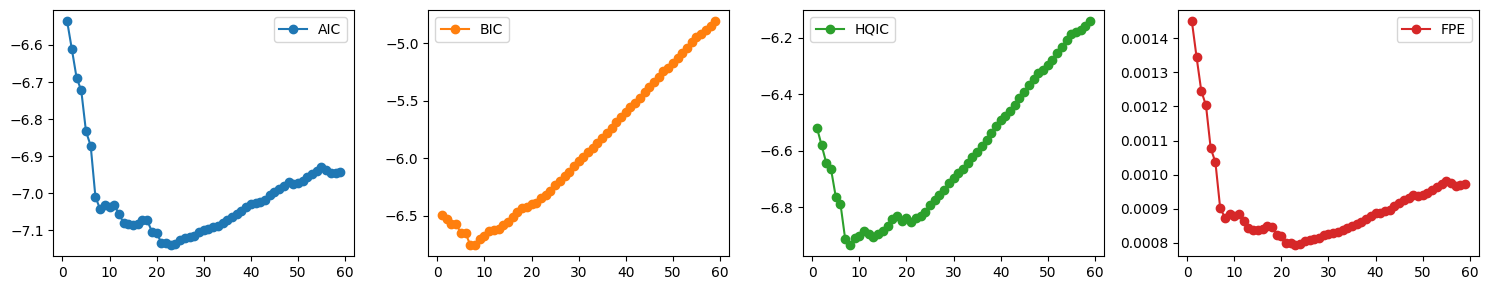

In [47]:
select_p(standardizirani_podaci)

<h1> 5. VAR model 3x3 </h1>

In [91]:
p = 8
model = VAR(standardizirani_podaci)
var_model = model.fit(p)

c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [49]:
from statsmodels.tsa.stattools import grangercausalitytests


def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [50]:
granger_causation_matrix(standardizirani_podaci, standardizirani_podaci.columns, p)  

c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: 

electricity_prices_x  gas_production_x  \
electricity_prices_y                  1.0000            0.0020   
gas_production_y                      0.0000            1.0000   
renewable_production_y                0.0113            0.0003   

                        renewable_production_x  
electricity_prices_y                    0.0010  
gas_production_y                        0.0099  
renewable_production_y                  1.0000

In [51]:
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 30, Jun, 2024
Time:                     11:31:38
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -6.75265
Nobs:                     1343.00    HQIC:                  -6.93436
Log likelihood:          -912.398    FPE:                0.000873343
AIC:                     -7.04319    Det(Omega_mle):     0.000826332
--------------------------------------------------------------------
Results for equation electricity_prices
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           0.002888         0.005562            0.519           0.604
L1.electricity_prices          -0.178572         0.027298           -6.542           0.000
L1.gas_

In [93]:
causality_gas_to_electricity = var_model.test_causality('electricity_prices', ['gas_production'], kind='f')
causality_renewable_to_electricity = var_model.test_causality('electricity_prices', ['renewable_production'], kind='f')
causality_gas_to_renewable = var_model.test_causality('renewable_production', ['gas_production'], kind='f')
causality_renewable_to_gas = var_model.test_causality('gas_production', ['renewable_production'], kind='f')

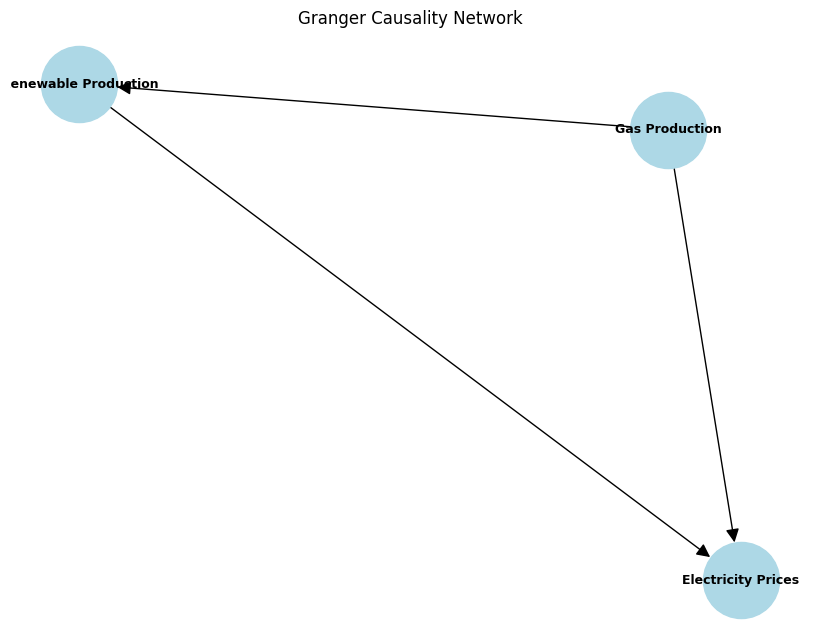

In [94]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes for each time series
G.add_node("Electricity Prices")
G.add_node("Gas Production")
G.add_node("Renewable Production")

# Add edges based on Granger causality results
# Replace p-values with the results obtained from the Granger causality tests
p_value_gas_to_electricity = causality_gas_to_electricity.pvalue
p_value_renewable_to_electricity = causality_renewable_to_electricity.pvalue
p_value_gas_to_renewable = causality_gas_to_renewable.pvalue
p_value_renewable_to_gas = causality_renewable_to_gas.pvalue

significance_level = 0.05

if p_value_gas_to_electricity < significance_level:
    G.add_edge("Gas Production", "Electricity Prices")

if p_value_renewable_to_electricity < significance_level:
    G.add_edge("Renewable Production", "Electricity Prices")

if p_value_gas_to_renewable < significance_level:
    G.add_edge("Gas Production", "Renewable Production")

if p_value_renewable_to_gas < significance_level:
    G.add_edge("Renewable Production", "Gas Production")

# Draw the directed graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=9, font_weight='bold', arrowsize=20)
plt.title("Granger Causality Network")
plt.show()


<h1> 2x2 pristup </h2>

In [54]:
import statsmodels.api as sm

# Function to perform Granger causality test on a pair of series
def granger_causality_test(data, max_lag):
    results = {}
    for col in data.columns:
        for col2 in data.columns:
            if col != col2:
                test_result = sm.tsa.stattools.grangercausalitytests(data[[col, col2]], max_lag, verbose=False)
                results[(col, col2)] = test_result
    return results

# Perform Granger causality tests pairwise
results = granger_causality_test(standardizirani_podaci[['electricity_prices', 'gas_production', 'renewable_production']], max_lag=7)

# Display results for each pair
for key, value in results.items():
    print(f'Granger Causality Test {key[0]} causes {key[1]}: p-value = {value[7][0]["ssr_ftest"][1]}')


c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: 

Granger Causality Test electricity_prices causes gas_production: p-value = 0.02788822386432844
Granger Causality Test electricity_prices causes renewable_production: p-value = 0.0966170375993921
Granger Causality Test gas_production causes electricity_prices: p-value = 7.650571561110746e-09
Granger Causality Test gas_production causes renewable_production: p-value = 0.01818267605285748
Granger Causality Test renewable_production causes electricity_prices: p-value = 0.012615462837637878
Granger Causality Test renewable_production causes gas_production: p-value = 0.0008304394269485427


c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC     24
BIC      8
HQIC    23
FPE     24
dtype: int32


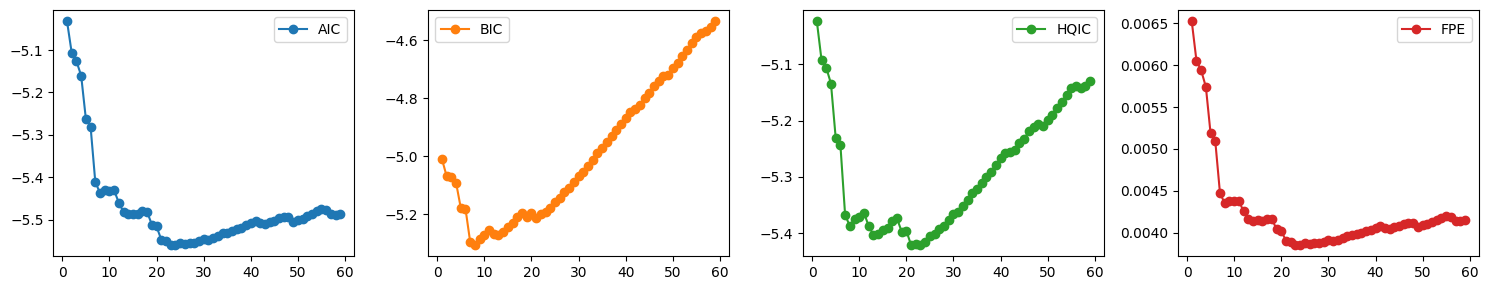

In [55]:
select_p(standardizirani_podaci[["electricity_prices", "gas_production"]])

c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC     23
BIC      8
HQIC    21
FPE     23
dtype: int32


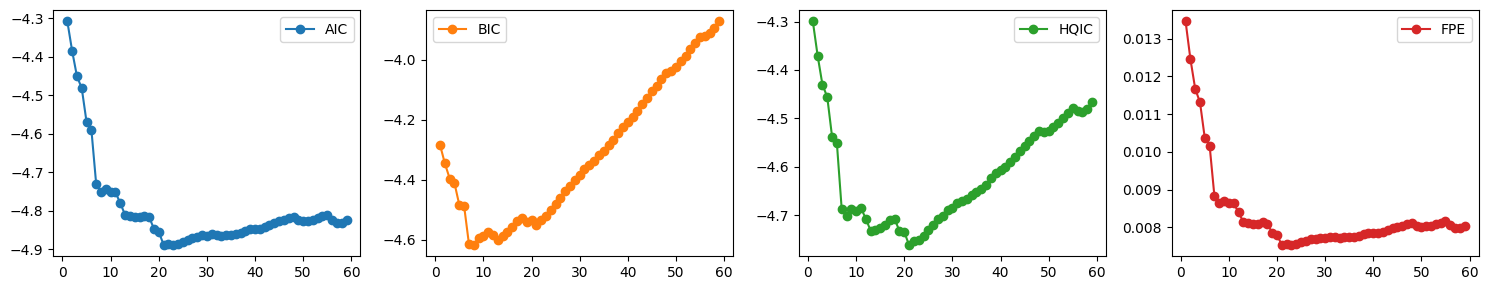

In [56]:
select_p(standardizirani_podaci[["electricity_prices", "renewable_production"]])

In [57]:
p = 8
model = VAR(standardizirani_podaci[["electricity_prices", "gas_production"]])
var_model = model.fit(p)

c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [58]:
granger_causation_matrix(standardizirani_podaci[["electricity_prices", "gas_production"]], standardizirani_podaci[["electricity_prices", "gas_production"]].columns, p)  

c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


electricity_prices_x  gas_production_x
electricity_prices_y                   1.0             0.002
gas_production_y                       0.0             1.000

In [59]:
causality_gas_to_electricity = var_model.test_causality('electricity_prices', ['gas_production'], kind='f')


In [60]:
causality_gas_to_electricity.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [61]:
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 30, Jun, 2024
Time:                     11:31:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.30523
Nobs:                     1343.00    HQIC:                  -5.38760
Log likelihood:          -126.364    FPE:                 0.00435280
AIC:                     -5.43694    Det(Omega_mle):      0.00424466
--------------------------------------------------------------------
Results for equation electricity_prices
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.002906         0.005599            0.519           0.604
L1.electricity_prices        -0.182014         0.027365           -6.651           0.000
L1.gas_producti

In [62]:
p = 8
model = VAR(standardizirani_podaci[["electricity_prices", "renewable_production"]])
var_model = model.fit(p)

c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [63]:
causality_renewable_to_electricity = var_model.test_causality('electricity_prices', ['renewable_production'], kind='f')


In [64]:
causality_renewable_to_electricity.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC     22
BIC      8
HQIC     8
FPE     22
dtype: int32


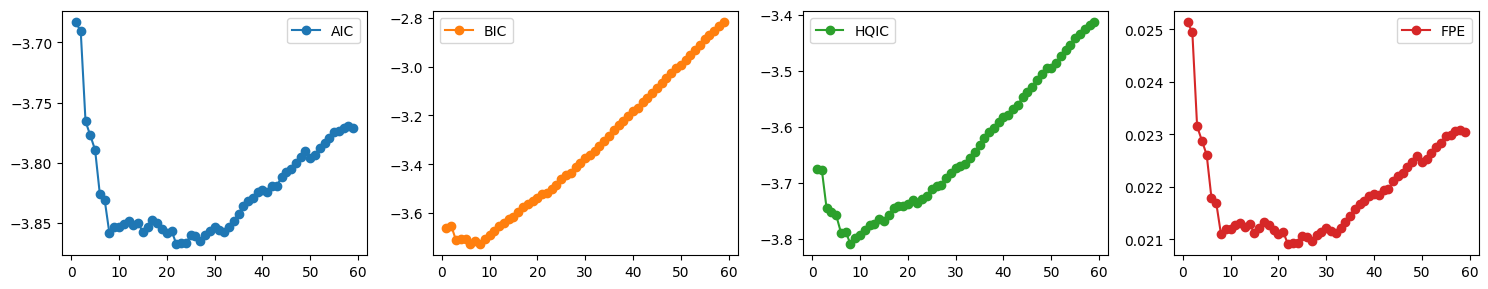

In [65]:
select_p(standardizirani_podaci[["gas_production", "renewable_production"]])

In [66]:
p = 8
model = VAR(standardizirani_podaci[["gas_production", "renewable_production"]])
var_model = model.fit(p)

c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [67]:
causality_gas_to_renewable = var_model.test_causality('renewable_production', ['gas_production'], kind='f')
causality_renewable_to_gas = var_model.test_causality('gas_production', ['renewable_production'], kind='f')

In [68]:
causality_gas_to_renewable.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [69]:
causality_renewable_to_gas.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

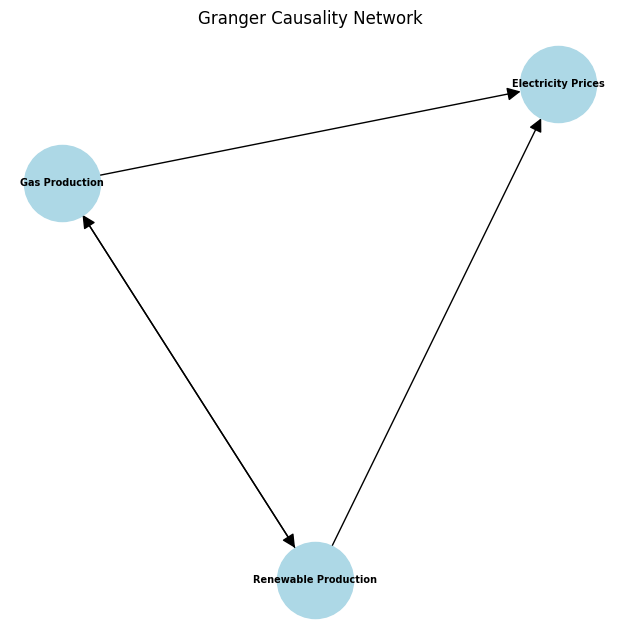

In [70]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes for each time series
G.add_node("Electricity Prices")
G.add_node("Gas Production")
G.add_node("Renewable Production")

# Add edges based on Granger causality results
# Replace p-values with the results obtained from the Granger causality tests
p_value_gas_to_electricity = causality_gas_to_electricity.pvalue
p_value_renewable_to_electricity = causality_renewable_to_electricity.pvalue
p_value_gas_to_renewable = causality_gas_to_renewable.pvalue
p_value_renewable_to_gas = causality_renewable_to_gas.pvalue

significance_level = 0.05

if p_value_gas_to_electricity < significance_level:
    G.add_edge("Gas Production", "Electricity Prices")

if p_value_renewable_to_electricity < significance_level:
    G.add_edge("Renewable Production", "Electricity Prices")

if p_value_gas_to_renewable < significance_level:
    G.add_edge("Gas Production", "Renewable Production")

if p_value_renewable_to_gas < significance_level:
    G.add_edge("Renewable Production", "Gas Production")

# Draw the directed graph
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=7, font_weight='bold', arrowsize=20)
plt.title("Granger Causality Network")
plt.show()


<h1> Svi izvori </h1>

In [71]:
daily_current_energy_data = daily_current_energy_data.drop(columns=["Marine", "Nuclear", "Other"])

In [72]:
daily_current_energy_data

Fossil Gas    COAL  Fossil Oil    HYDRO  Solar  Waste  Other renewable  \
0         5107.0     0.0       426.0  10163.0   72.0    0.0           1104.0   
1         5136.0     0.0       465.0  15578.0   79.0    0.0           1104.0   
2         6123.0     0.0       483.0  17011.0  116.0    0.0           1104.0   
3         7256.0     0.0       490.0  13418.0  104.0    0.0           1056.0   
4         9411.0     0.0       466.0  13545.0   18.0    0.0           1104.0   
...          ...     ...         ...      ...    ...    ...              ...   
1347      9587.0  4460.0         0.0   5286.0  260.0  144.0            775.0   
1348      9719.0    25.0         0.0   6082.0  317.0  149.0            747.0   
1349      7693.0     0.0         0.0   4905.0  308.0  149.0            747.0   
1350     11263.0     0.0         0.0   7117.0  331.0  149.0            723.0   
1351     11644.0     0.0         0.0   8141.0  351.0  149.0            788.0   

      Wind Onshore  Biomass       Datum  Geothermal  Obnovljivi      CROPEX  
0           4684.0    960.0  01.01.2019         NaN     16983.0   36.554583  
1           6981.0    960.0  02.01.2019         NaN     24702.0   52.980417  
2           7999.0    960.0  03.01.2019         NaN     27190.0   61.434167  
3           9682.0    960.0  04.01.2019         NaN     25220.0   66.302083  
4           4678.0    960.0  05.01.2019         NaN     20305.0   63.445000  
...            ...      ...         ...         ...         ...         ...  
1347        3898.0   1724.0  09.09.2022       155.0     11943.0  377.266250  
1348        1726.0   1673.0  10.09.2022       158.0     10545.0  404.317917  
1349        4213.0   1693.0  11.09.2022       164.0     11866.0  391.565833  
1350        5536.0   1654.0  12.09.2022       169.0     15361.0  437.792917  
1351        2296.0   1642.0  13.09.2022       161.0     13218.0  448.740417  

[1352 rows x 13 columns]

In [73]:
columns_to_remove = ["Fossil Gas", "Datum", "Obnovljivi", "CROPEX"]
all_energy_sources = daily_current_energy_data.drop(columns=columns_to_remove)

In [74]:
all_energy_sources

COAL  Fossil Oil    HYDRO  Solar  Waste  Other renewable  \
0        0.0       426.0  10163.0   72.0    0.0           1104.0   
1        0.0       465.0  15578.0   79.0    0.0           1104.0   
2        0.0       483.0  17011.0  116.0    0.0           1104.0   
3        0.0       490.0  13418.0  104.0    0.0           1056.0   
4        0.0       466.0  13545.0   18.0    0.0           1104.0   
...      ...         ...      ...    ...    ...              ...   
1347  4460.0         0.0   5286.0  260.0  144.0            775.0   
1348    25.0         0.0   6082.0  317.0  149.0            747.0   
1349     0.0         0.0   4905.0  308.0  149.0            747.0   
1350     0.0         0.0   7117.0  331.0  149.0            723.0   
1351     0.0         0.0   8141.0  351.0  149.0            788.0   

      Wind Onshore  Biomass  Geothermal  
0           4684.0    960.0         NaN  
1           6981.0    960.0         NaN  
2           7999.0    960.0         NaN  
3           9682.0    960.0         NaN  
4           4678.0    960.0         NaN  
...            ...      ...         ...  
1347        3898.0   1724.0       155.0  
1348        1726.0   1673.0       158.0  
1349        4213.0   1693.0       164.0  
1350        5536.0   1654.0       169.0  
1351        2296.0   1642.0       161.0  

[1352 rows x 9 columns]

In [75]:
df_all_energy = pd.DataFrame({
    "coal": all_energy_sources["COAL"],
    "oil": all_energy_sources["Fossil Oil"],
    "hydro": all_energy_sources["HYDRO"],
    "solar": all_energy_sources["Solar"],
    "waste": all_energy_sources["Waste"],
    "other_renewable": all_energy_sources["Other renewable"],
    "wind": all_energy_sources["Wind Onshore"],
    "biomass": all_energy_sources["Biomass"],
    "geothermal": all_energy_sources["Geothermal"]
})

In [76]:
scaler = StandardScaler()
df_all_energy_standardized = pd.DataFrame(scaler.fit_transform(df_all_energy), columns=df_all_energy.columns)


In [77]:
df_all_energy_standardized

coal       oil     hydro     solar     waste  other_renewable  \
0    -1.146897  2.567281 -0.615590 -1.300101 -1.481571         0.724562   
1    -1.146897  2.855179  0.096830 -1.242182 -1.481571         0.724562   
2    -1.146897  2.988055  0.285362 -0.936040 -1.481571         0.724562   
3    -1.146897  3.039729 -0.187348 -1.035329 -1.481571         0.194076   
4    -1.146897  2.862561 -0.170640 -1.746903 -1.481571         0.724562   
...        ...       ...       ...       ...       ...              ...   
1347  0.868181 -0.577450 -1.257229  0.255433  1.964719        -2.911472   
1348 -1.135602 -0.577450 -1.152504  0.727057  2.084382        -3.220922   
1349 -1.146897 -0.577450 -1.307355  0.652590  2.084382        -3.220922   
1350 -1.146897 -0.577450 -1.016335  0.842895  2.084382        -3.486165   
1351 -1.146897 -0.577450 -0.881613  1.008377  2.084382        -2.767799   

          wind   biomass  geothermal  
0    -0.090108 -1.807584         NaN  
1     0.485801 -1.807584         NaN  
2     0.741037 -1.807584         NaN  
3     1.163003 -1.807584         NaN  
4    -0.091612 -1.807584         NaN  
...        ...       ...         ...  
1347 -0.287176  1.114693   -0.867934  
1348 -0.831745  0.919619   -0.812104  
1349 -0.208198  0.996119   -0.700445  
1350  0.123507  0.846945   -0.607396  
1351 -0.688833  0.801045   -0.756275  

[1352 rows x 9 columns]

In [78]:
geothermal_energy = df_all_energy_standardized["geothermal"].dropna()
geothermal_energy_std, d1 = difference_until_stationary(geothermal_energy)



In [79]:
df_all_energy_standardized = df_all_energy_standardized.drop(columns="geothermal")

In [80]:
for energy in df_all_energy_standardized.columns:

    rez = ADF_test(df_all_energy_standardized[energy], energy)
    if p > 0.05:
        
        df_all_energy_standardized[energy], d1 = difference_until_stationary(df_all_energy_standardized[energy])
        print(energy, d1)
    

 > Is the coal stationary?
Test statistic = -3.132
P-value = 0.024
Critical values :
	1%: -3.435 - The data is not stationary with 99% confidence
	5%: -2.864 - The data is  stationary with 95% confidence
	10%: -2.568 - The data is  stationary with 90% confidence
coal 0
 > Is the oil stationary?
Test statistic = -3.190
P-value = 0.021
Critical values :
	1%: -3.435 - The data is not stationary with 99% confidence
	5%: -2.864 - The data is  stationary with 95% confidence
	10%: -2.568 - The data is  stationary with 90% confidence
oil 0
 > Is the hydro stationary?
Test statistic = -3.212
P-value = 0.019
Critical values :
	1%: -3.435 - The data is not stationary with 99% confidence
	5%: -2.864 - The data is  stationary with 95% confidence
	10%: -2.568 - The data is  stationary with 90% confidence
hydro 0
 > Is the solar stationary?
Test statistic = -2.053
P-value = 0.264
Critical values :
	1%: -3.435 - The data is not stationary with 99% confidence
	5%: -2.864 - The data is not stationary wi

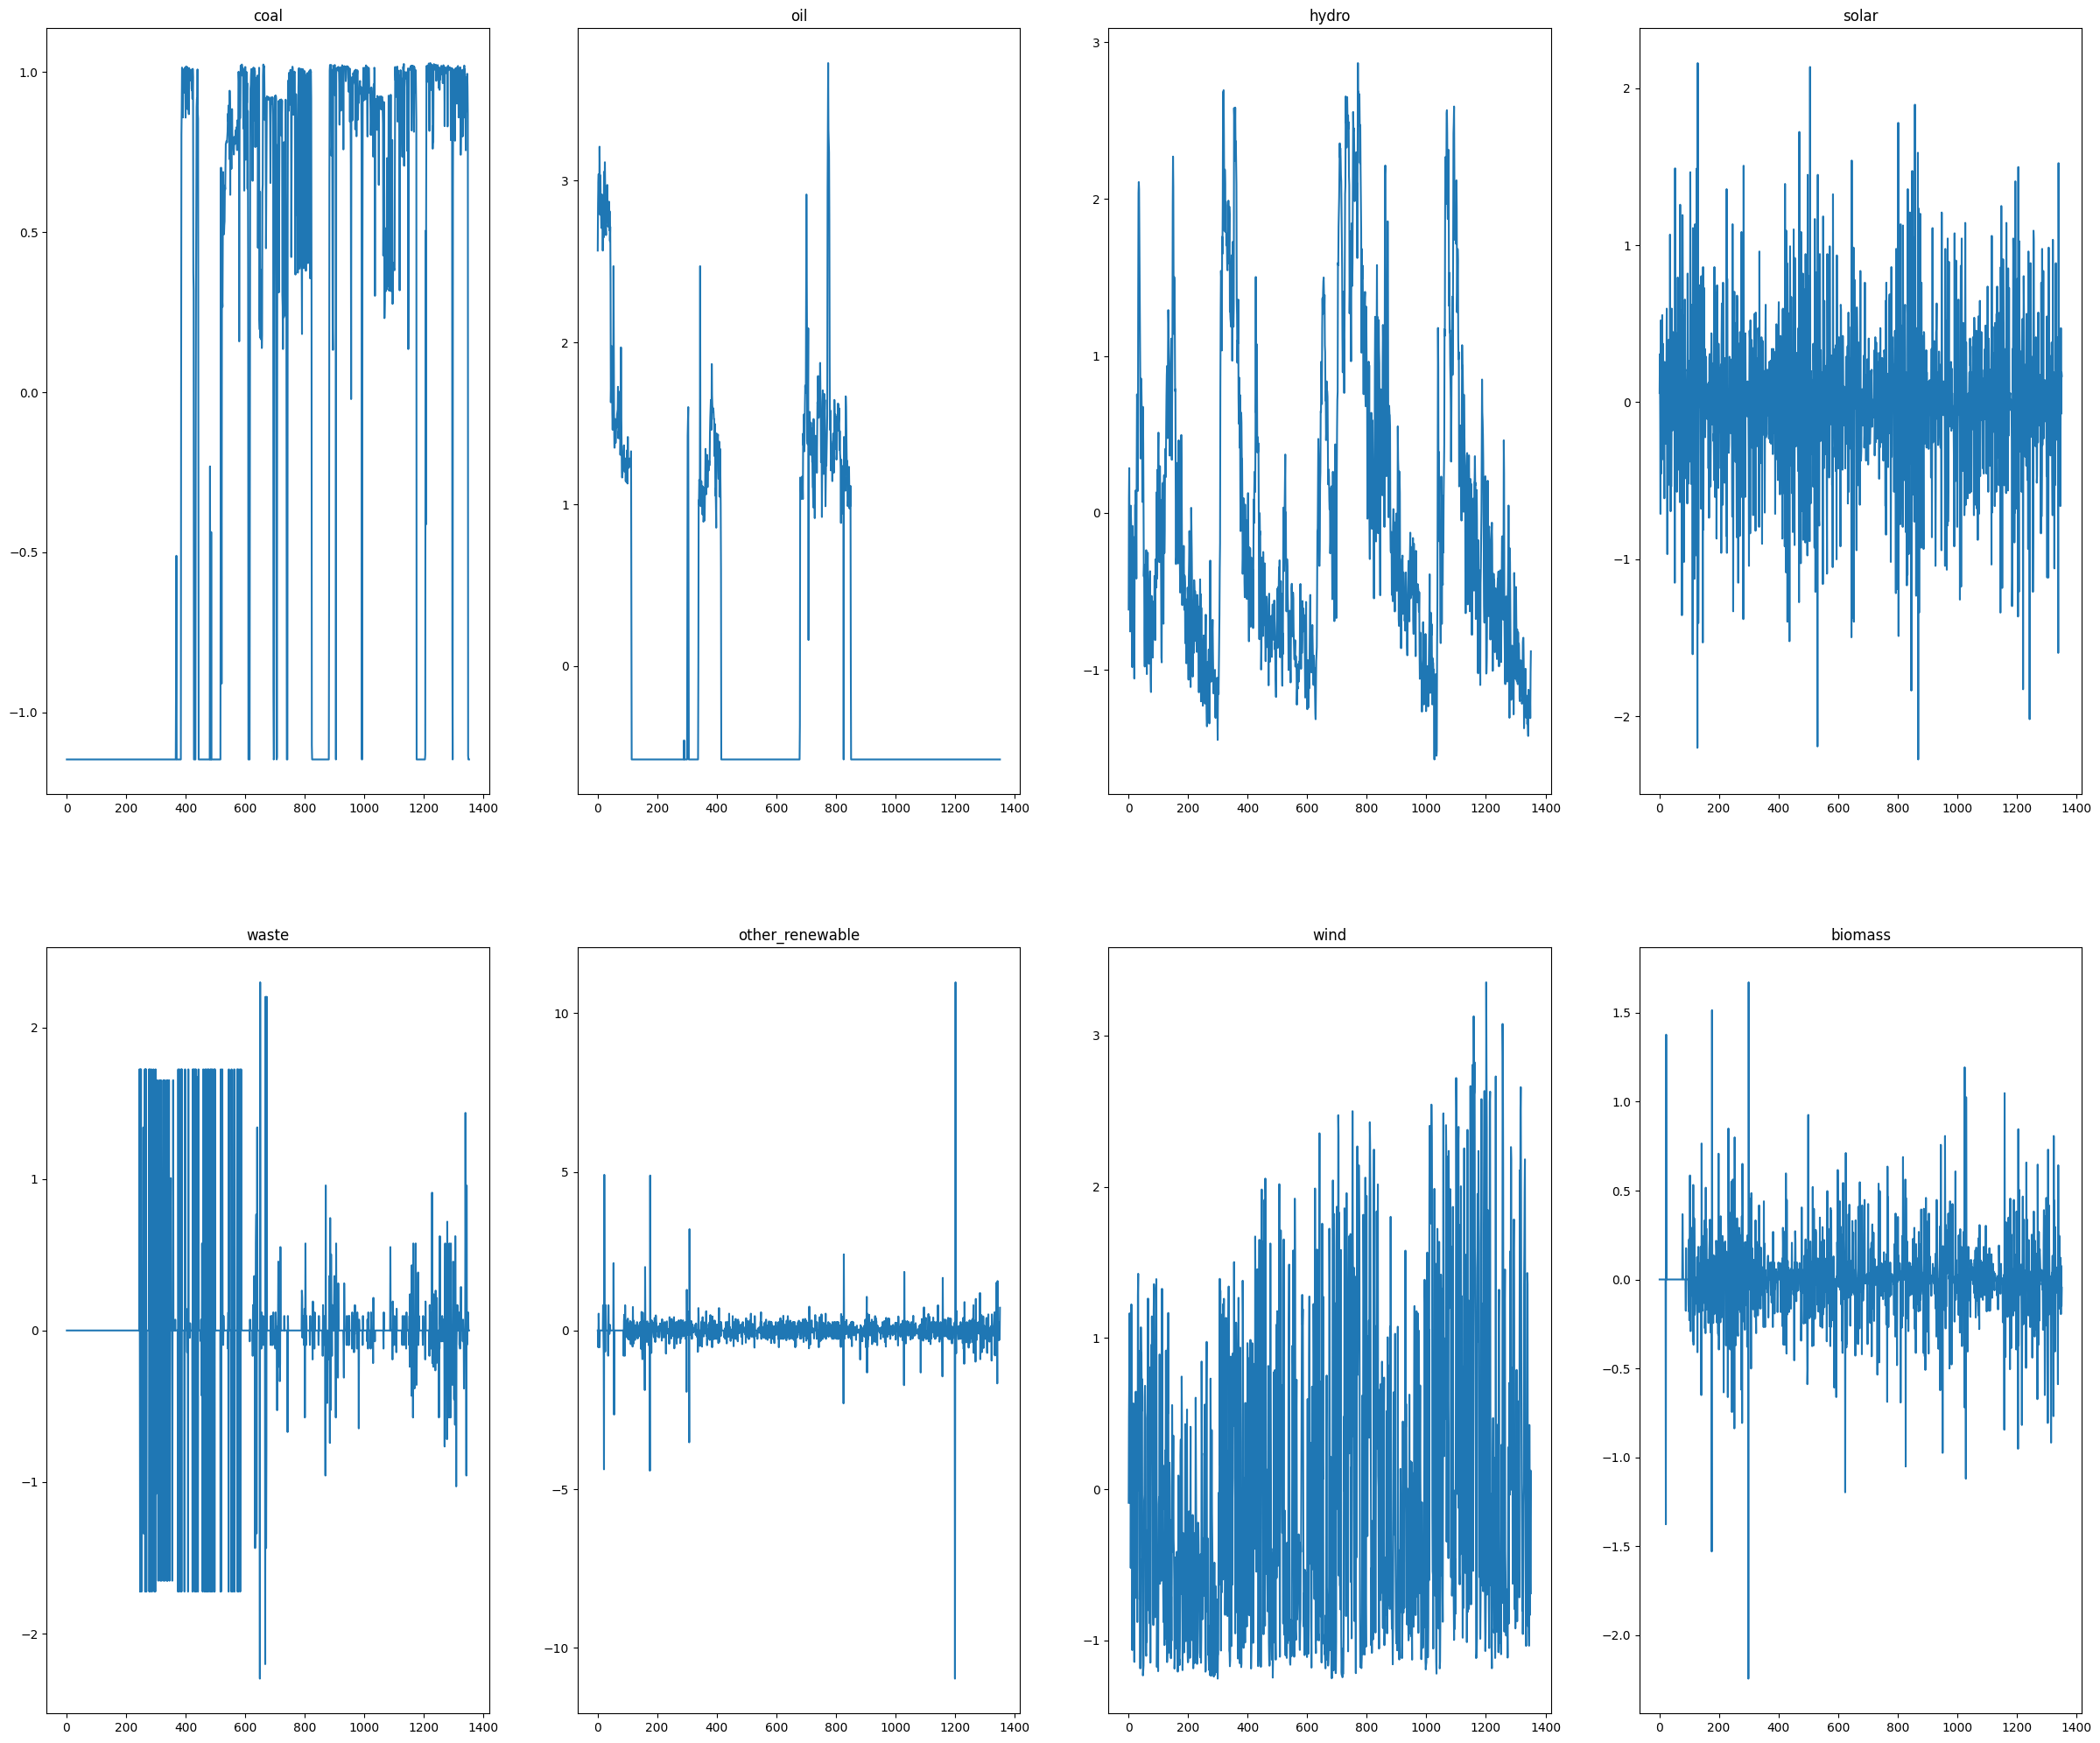

In [81]:
visualizeEnergyPorduction(df_all_energy_standardized)

In [82]:
standardizirana_struja = standardizirani_podaci["electricity_prices"]
df_all_energy_standardized["struja"] = standardizirana_struja

In [83]:
df_all_energy_standardized = df_all_energy_standardized.dropna()

coal


c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC     21
BIC      7
HQIC    21
FPE     21
dtype: int32
oil


c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC     21
BIC      8
HQIC    21
FPE     21
dtype: int32
hydro


c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC     36
BIC      8
HQIC    22
FPE     36
dtype: int32
solar


c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC     21
BIC      8
HQIC    21
FPE     21
dtype: int32
waste


c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC     22
BIC      7
HQIC    21
FPE     22
dtype: int32
other_renewable


c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC     58
BIC      7
HQIC    23
FPE     58
dtype: int32
wind


c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC     21
BIC      7
HQIC    21
FPE     21
dtype: int32
biomass


c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC     24
BIC      7
HQIC    23
FPE     24
dtype: int32
struja


c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


LinAlgError: 2-th leading minor of the array is not positive definite

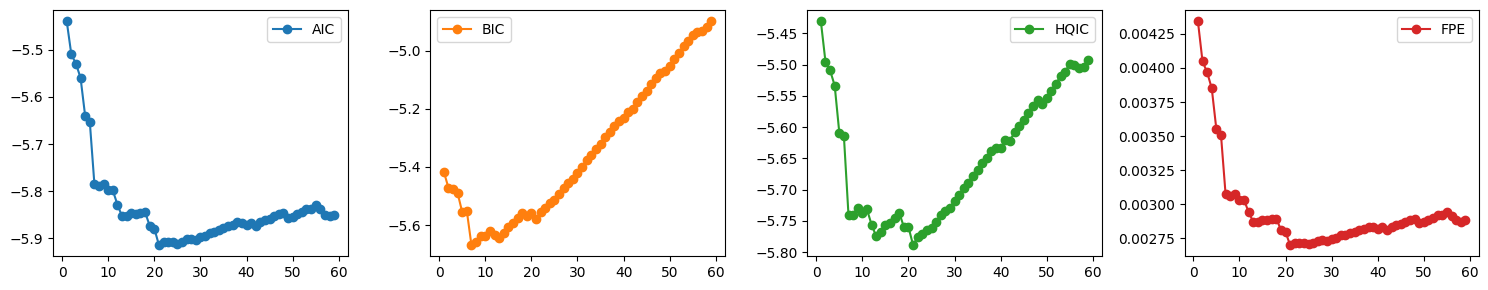

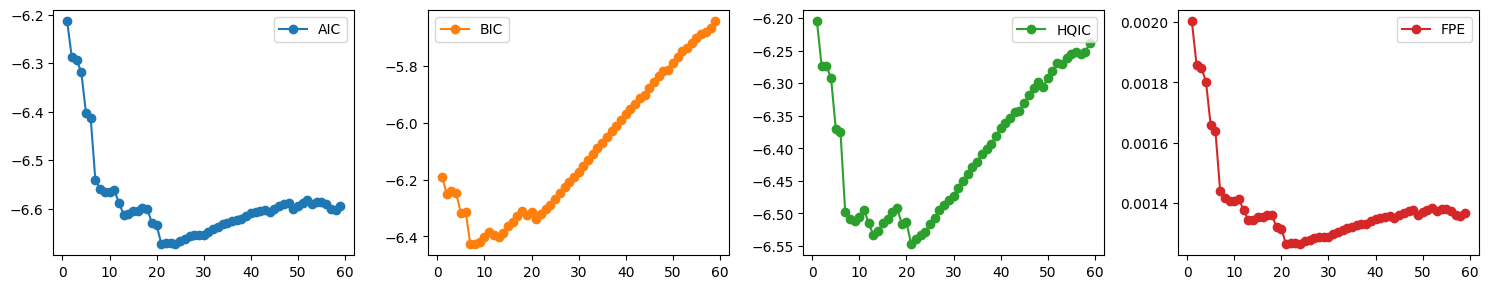

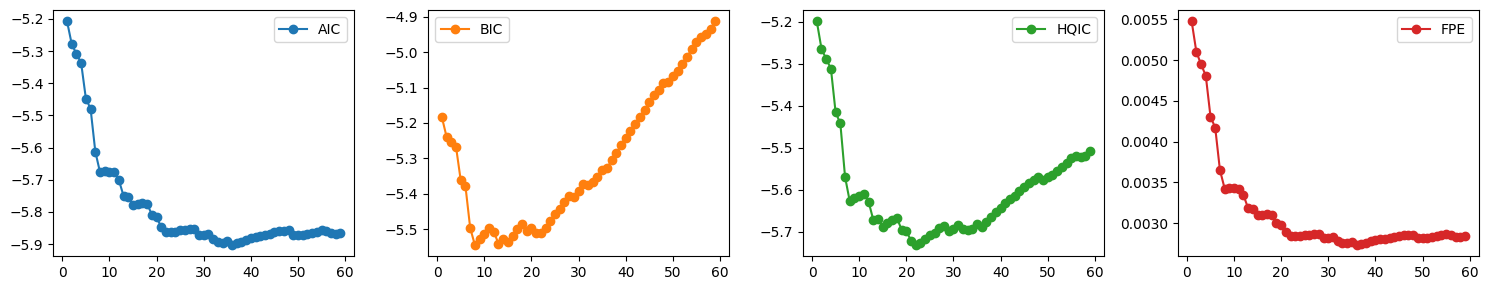

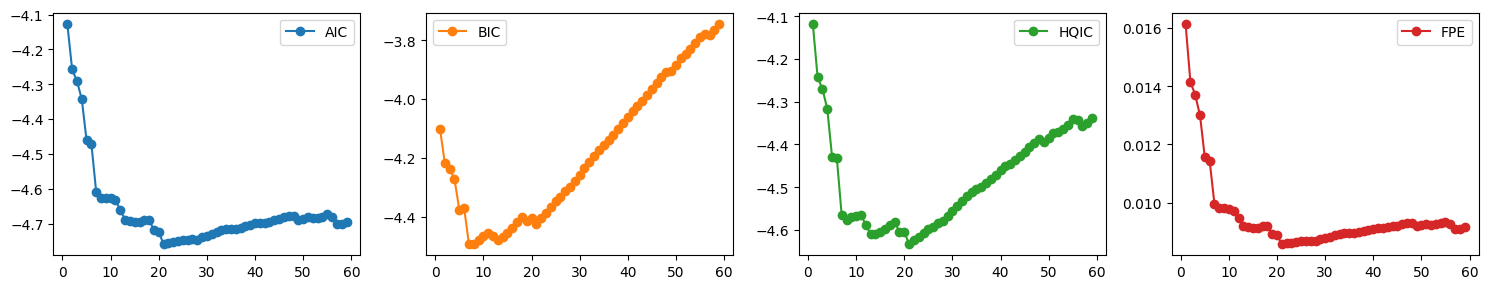

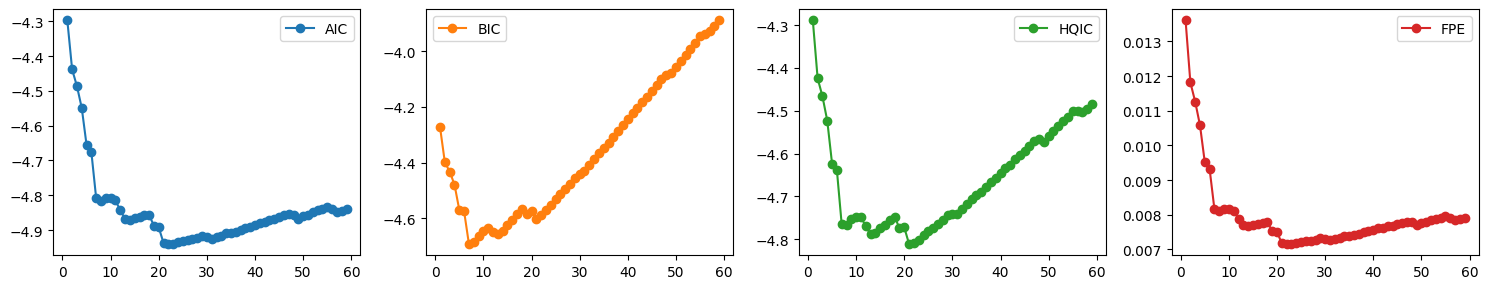

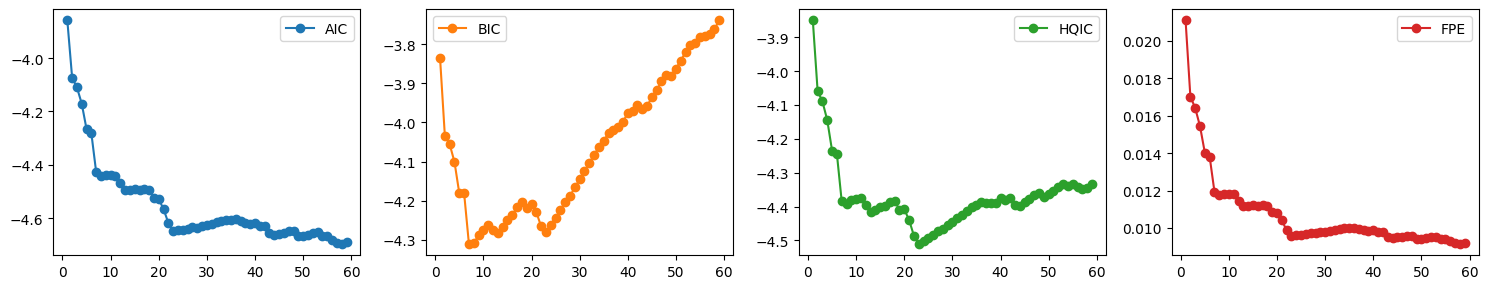

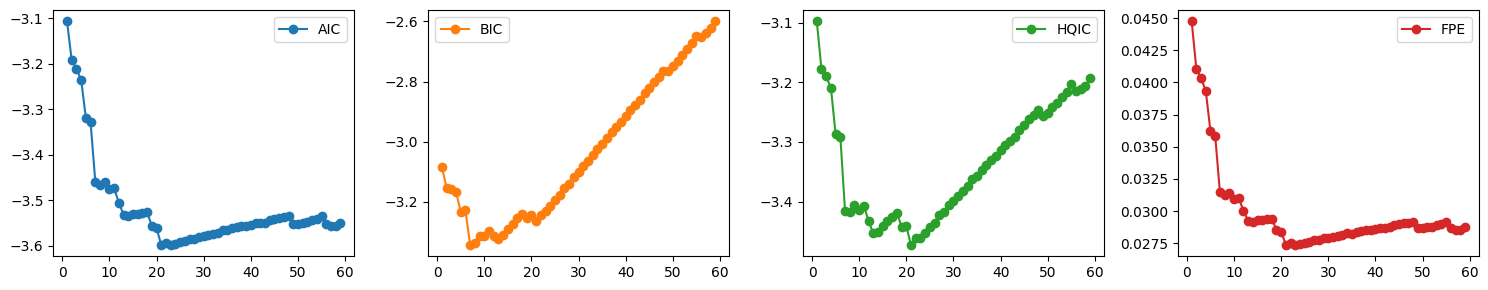

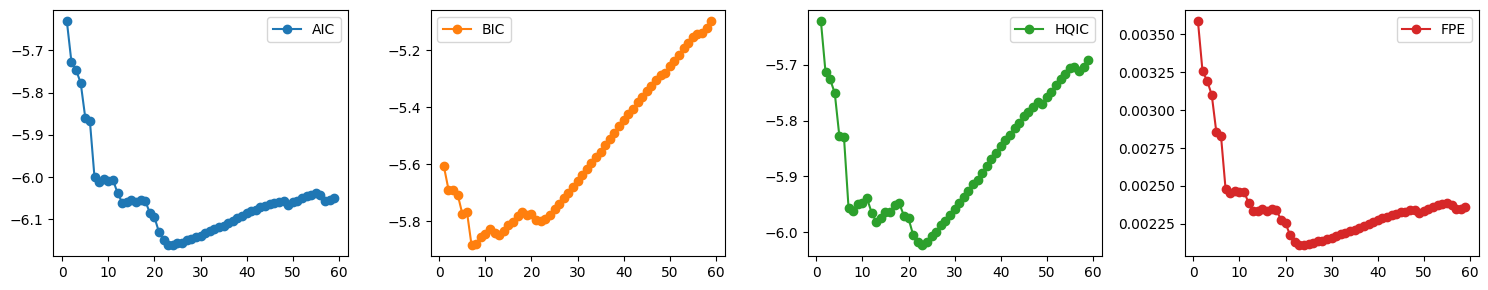

In [84]:
for energy in df_all_energy_standardized.columns:
    print(energy)
    select_p(df_all_energy_standardized[["struja", energy]])

In [ ]:
coal_p = [21, 7]
oil_p = [21, 8]
hydro_p = [36, 8, 22]
solar_p = [21, 8]
waste_p = [21, 22, 7]
other_ren_p = [58, 7, 23]
wind_p = [21, 7]
biomass_p = [24, 23, 7]




In [ ]:
energy_ps = [coal_p, oil_p, hydro_p, solar_p, waste_p, other_ren_p, wind_p, biomass_p]

In [ ]:
for i, type in enumerate(df_all_energy_standardized.columns):
    if type == "struja":
        break
    ps = energy_ps[i]
    for p in ps:
        print(type, p)

        model = VAR(df_all_energy_standardized[["struja", type]])
        var_model = model.fit(p)
        causality_energy_to_electricity = var_model.test_causality('struja', [type], kind='f')

        print(causality_energy_to_electricity.summary())

coal 21
Granger causality F-test. H_0: coal does not Granger-cause struja. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         1.135          1.560   0.302 (21, 2574)
------------------------------------------------
coal 7
Granger causality F-test. H_0: coal does not Granger-cause struja. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.449          2.013   0.181 (7, 2658)
-----------------------------------------------
oil 21
Granger causality F-test. H_0: oil does not Granger-cause struja. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
        0.2732          1.560   1.000 (21, 2574)
------------------------------------------------
oil 8
Granger causality

c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ign

Granger causality F-test. H_0: waste does not Granger-cause struja. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
        0.4202          1.546   0.992 (22, 2568)
------------------------------------------------
waste 7
Granger causality F-test. H_0: waste does not Granger-cause struja. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.5916          2.013   0.763 (7, 2658)
-----------------------------------------------
other_renewable 58
Granger causality F-test. H_0: other_renewable does not Granger-cause struja. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         1.344          1.330   0.044 (58, 2352)
------------------------------------------------
other_renewa

c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ign

In [ ]:
geo_and_current = pd.merge(geothermal_energy_std, standardizirana_struja, right_index=True, left_index=True)

In [ ]:
geo_and_current

geothermal  electricity_prices
365     0.713908           -0.007632
366     0.713908            0.065122
367     0.713908            0.031436
368     0.713908            0.034547
369     0.713908           -0.108015
...          ...                 ...
1347   -0.867934           -0.713826
1348   -0.812104            0.236519
1349   -0.700445           -0.111494
1350   -0.607396            0.404174
1351   -0.756275            0.095716

[987 rows x 2 columns]

c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC     21
BIC      7
HQIC     7
FPE     21
dtype: int32


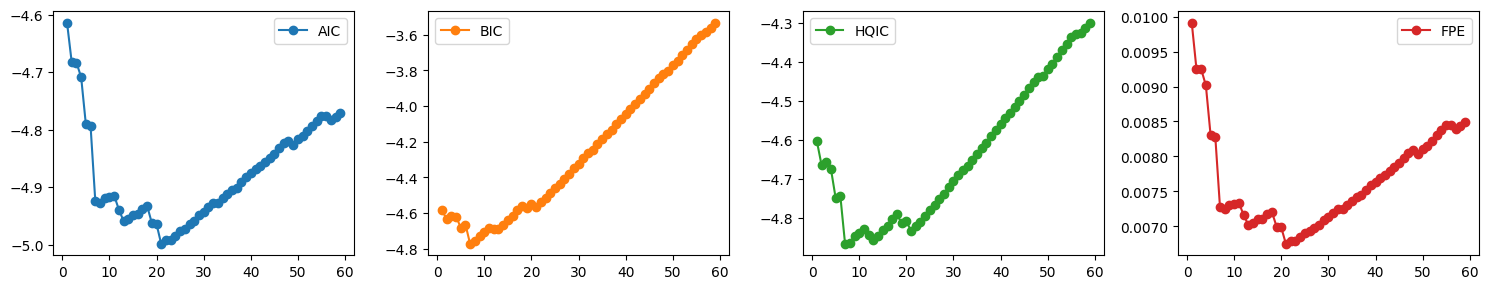

In [ ]:
select_p(geo_and_current[["electricity_prices", "geothermal"]])

In [ ]:
model = VAR(geo_and_current[["electricity_prices", "geothermal"]])
var_model = model.fit(21)
causality_energy_to_electricity = var_model.test_causality('electricity_prices', ["geothermal"], kind='f')

print(causality_energy_to_electricity.summary())

Granger causality F-test. H_0: geothermal does not Granger-cause electricity_prices. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
        0.7711          1.562   0.758 (21, 1846)
------------------------------------------------


c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
model = VAR(geo_and_current[["electricity_prices", "geothermal"]])
var_model = model.fit(7)
causality_energy_to_electricity = var_model.test_causality('electricity_prices', ["geothermal"], kind='f')

print(causality_energy_to_electricity.summary())

Granger causality F-test. H_0: geothermal does not Granger-cause electricity_prices. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.141          2.014   0.334 (7, 1930)
-----------------------------------------------


c:\Users\Zoran Barac\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


: 